## tradeSeq for DE along fallopian tube axis (epithelial spots) in female reproductive tract

In [1]:
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("tradeSeq")

In [2]:
library(tradeSeq)
library(SingleCellExperiment)
library(slingshot)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [3]:
adata <- readRDS("//lustre/scratch126/cellgen/team292/vl6/VISIUM/femalereproductiveaxis_epi_cytassist_downsampled_fallopiantube.rds")
adata


class: SingleCellExperiment 
dim: 14641 151 
metadata(0):
assays(1): X
rownames(14641): SAMD11 NOC2L ... DEPRECATED_ENSG00000272391
  DEPRECATED_ENSG00000275464
rowData names(2): n_cells n_counts
colnames(151): HCA_F_RepTsp13902018_AACCAAGGTATCAGGC-1
  HCA_F_RepTsp13902018_AAGGACCAACATGGCT-1 ...
  HCA_F_RepTsp15070471_TGTCGTTCATACGATA-1
  HCA_F_RepTsp15070471_TGTTACCTATTGGACA-1
colData names(2): sample FemaleReproductiveAxis
reducedDimNames(0):
altExpNames(0):

In [4]:
counts <- assay(adata, "X")

In [5]:
set.seed(7)
pseudotime <- colData(adata)$FemaleReproductiveAxis
cellWeights <- rep(1, 151)

In [6]:
#icMat <- evaluateK(counts = counts, sds = SlingshotDataSet(adata), k = 3:10, 
#                   nGenes = 200, verbose = T)

In [7]:
library(scran)

In [8]:
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(adata) <- log2(t(t(counts)/size.factors) + 1)
assayNames(adata)

[1] "X"         "logcounts"

In [9]:
# Filter genes with non-zero biological components
getVariableGenes <- function(adata,fdr_thresh=NULL,var_thresh=0) {
  gene_var <- modelGeneVar(adata)
  genes <- getTopHVGs(gene_var, var.threshold =var_thresh ,fdr.threshold = fdr_thresh)
  return(genes)
}

In [10]:
genes <- getVariableGenes(adata)

In [11]:
length(genes)

[1] 7104

In [12]:
dim(counts[genes,])

[1] 7104  151

In [13]:
sce <- fitGAM(counts = counts[genes,], pseudotime = pseudotime, cellWeights = cellWeights, nknots = 5,
                verbose = TRUE, parallel = TRUE)

  |======================================================================| 100%



In [14]:
table(rowData(sce)$tradeSeq$converged)


TRUE 
7104 

In [15]:
adata <- adata[genes, ]

In [16]:
adata

class: SingleCellExperiment 
dim: 7104 151 
metadata(0):
assays(2): X logcounts
rownames(7104): TPPP3 SFRP4 ... PLG ZNF423
rowData names(2): n_cells n_counts
colnames(151): HCA_F_RepTsp13902018_AACCAAGGTATCAGGC-1
  HCA_F_RepTsp13902018_AAGGACCAACATGGCT-1 ...
  HCA_F_RepTsp15070471_TGTCGTTCATACGATA-1
  HCA_F_RepTsp15070471_TGTTACCTATTGGACA-1
colData names(2): sample FemaleReproductiveAxis
reducedDimNames(0):
altExpNames(0):

### ASSOCIATION TEST

A first exploration of the data analysis may consist of checking whether gene expression is associated with a particular lineage. The statistical test performed here, implemented in the associationTest function, is testing the null hypothesis that all smoother coefficients are equal to each other. This can be interpreted as testing whether the average gene expression is significantly changing along pseudotime.



In [27]:
assoRes <- associationTest(sce)
head(assoRes)

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
TPPP3,95.077904,3,0.000000e+00,1.1381158
SFRP4,41.912768,3,4.186831e-09,0.6636395
ATF3,77.436201,3,1.110223e-16,1.2192923
PLEC,1.213572,3,7.497510e-01,0.2238545
NR4A1,71.374497,3,2.220446e-15,0.7531815
PTMS,3.535014,3,3.162493e-01,0.3108044


In [28]:
write.csv(assoRes, file = '/nfs/team292/vl6/FetalReproductiveTract/manuscript_v1/supp_tables/SupplementaryTable8_fallopian_epi_cytassist.csv')


In order to discover marker genes of the progenitor or differentiated cell population, researchers may be interested in assessing differential expression between the progenitor cell population (i.e., the starting point of a lineage) with the differentiated cell type population (i.e., the end point of a lineage). The function startVsEndTest uses a Wald test to assess the null hypothesis that the average expression at the starting point of the smoother (progenitor population) is equal to the average expression at the end point of the smoother (differentiated population). The test basically involves a comparison between two smoother coefficients for every lineage. The function startVsEndTest performs a global test across all lineages by default (i.e. it compares the start and end positions for all lineages simultaneously), but you can also assess all lineages separately by setting lineages=TRUE. Below, we adopt an omnibus test across the two lineages.

### Genes strongly associated with pseudotime 

In [36]:
assoRes = assoRes[assoRes$pvalue < 0.001,]

In [37]:
dim(assoRes)

[1] 1575    4

In [38]:
assoRes['PNOC', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
PNOC,685.7579,3,0,1.347466


In [39]:
assoRes['CRTAC1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
CRTAC1,142.9889,3,0,0.699361


In [40]:
assoRes['LYPD1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA


In [41]:
assoRes['ERP27', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
ERP27,99.444,3,0,0.4838477


In [46]:
assoRes['ROS1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
ROS1,42.23555,3,3.575908e-09,1.15087


In [45]:
assoRes['MUC6', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
MUC6,95.07875,3,0,0.7365278


In [47]:
assoRes = assoRes[assoRes$meanLogFC > 0.5, ]

In [48]:
dim(assoRes)

[1] 1575    4

In [49]:
assoRes = assoRes[assoRes$waldStat > 80, ]

In [50]:
dim(assoRes)

[1] 464   4

In [51]:
write.csv(assoRes, file = "/lustre/scratch126/cellgen/team292/vl6/VISIUM/FallopianAxis_epi_genes.csv",
          row.names = TRUE)

In [52]:
assoRes['PNOC', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
PNOC,685.7579,3,0,1.347466


In [53]:
assoRes['CRTAC1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
CRTAC1,142.9889,3,0,0.699361


In [54]:
assoRes['LYPD1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA


In [55]:
assoRes['ERP27', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
ERP27,99.444,3,0,0.4838477


In [56]:
assoRes['ROS1', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
ROS1,42.23555,3,3.575908e-09,1.15087


In [57]:
assoRes['MUC6', ]

,waldStat,df,pvalue,meanLogFC
,<dbl>,<dbl>,<dbl>,<dbl>
MUC6,95.07875,3,0,0.7365278


In [58]:
assoRes = assoRes[order(assoRes$waldStat, decreasing = TRUE),]

In [62]:
# Get the index of the DataFrame
tops <- row.names(assoRes)[1:50]
tops

[1] "PNOC"      "RNASE1"    "CLDN6"     "RASSF10"   "RSPO1"     "HOXA9"    
 [7] "MSLN"      "GATA6"     "TSPAN7"    "DOK5"      "PROM1"     "PPP2R2B"  
[13] "WT1"       "AIF1L"     "ARL4C"     "C19orf33"  "SERPINE2"  "ASS1"     
[19] "AFAP1L2"   "RANGRF"    "WNT10A"    "LRIG1"     "EGR1"      "UPK3B"    
[25] "CRTAC1"    "CKB"       "DLGAP1"    "TMEM101"   "TNFRSF12A" "ADAM28"   
[31] "GALNT17"   "MMP28"     "ADAMTS1"   "ACTG2"     "ACTA2"     "ALDH1A2"  
[37] "TUBB2B"    "CD109"     "MYLK"      "AAK1"      "IGFBP7"    "EFNB2"    
[43] "ADCY5"     "COL23A1"   "SORL1"     "ARHGEF19"  "SYNE2"     "MYH11"    
[49] "PCDH1"     "ERP27"

In [59]:
library(ggplot2)

[1] "PNOC"
[1] "RNASE1"


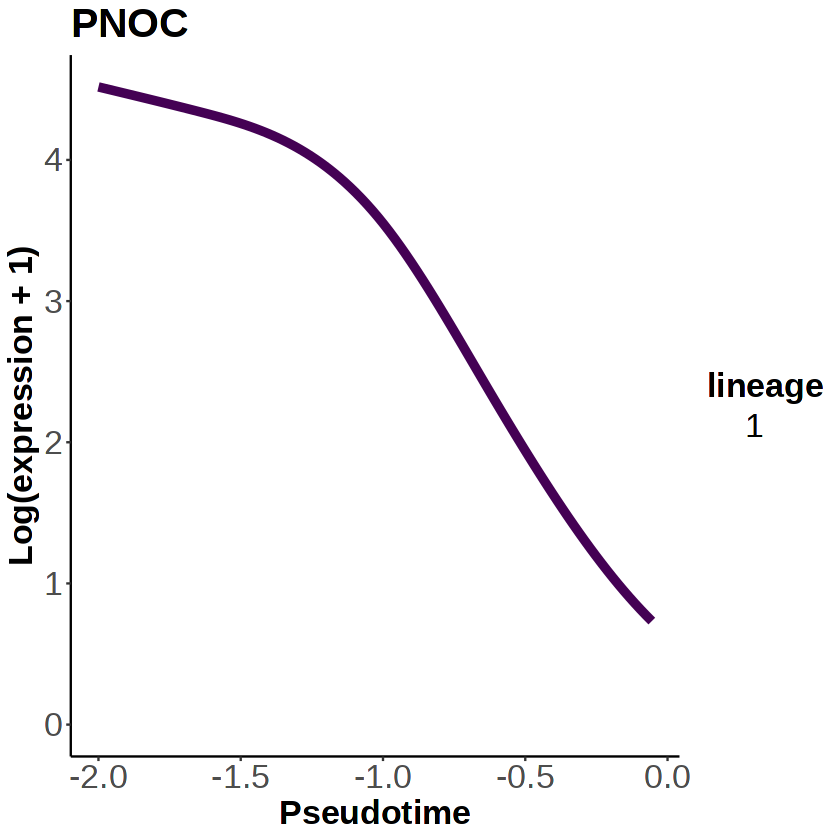

[1] "CLDN6"


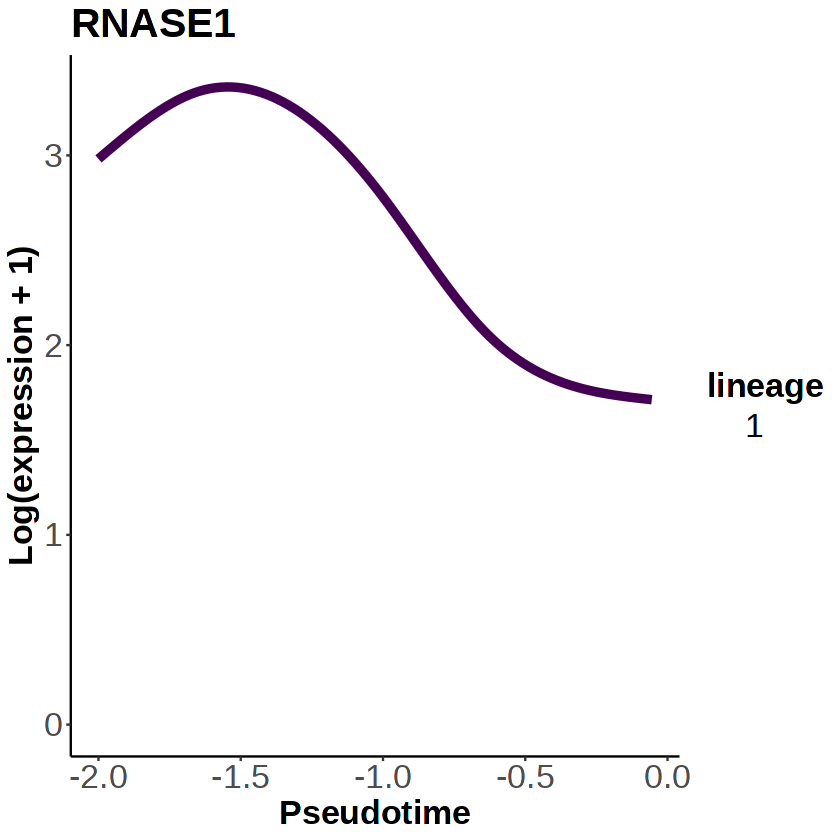

[1] "RASSF10"


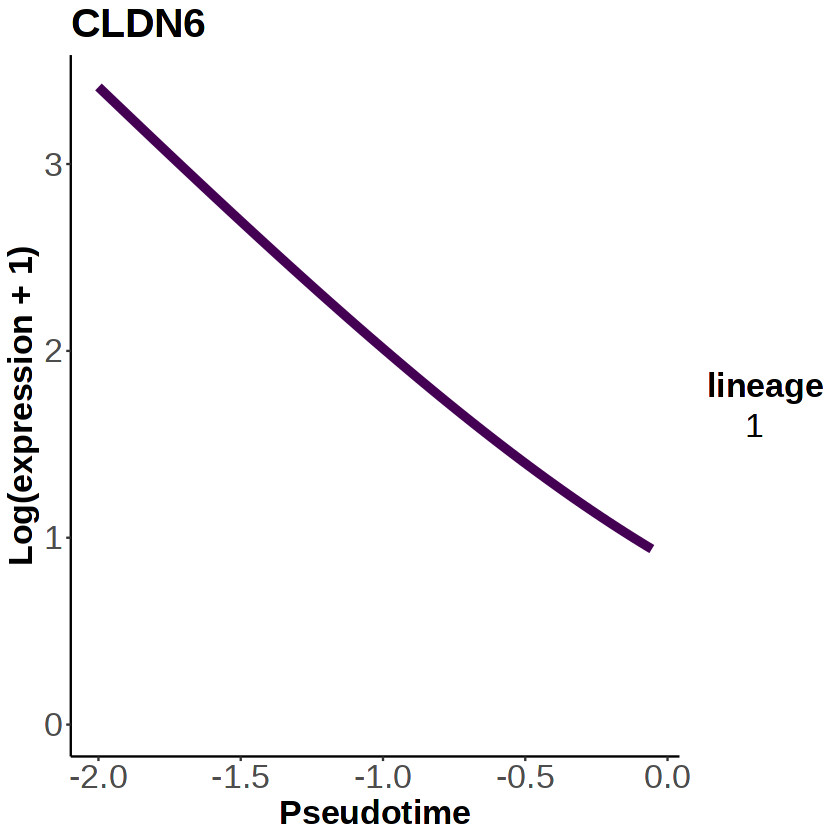

[1] "RSPO1"


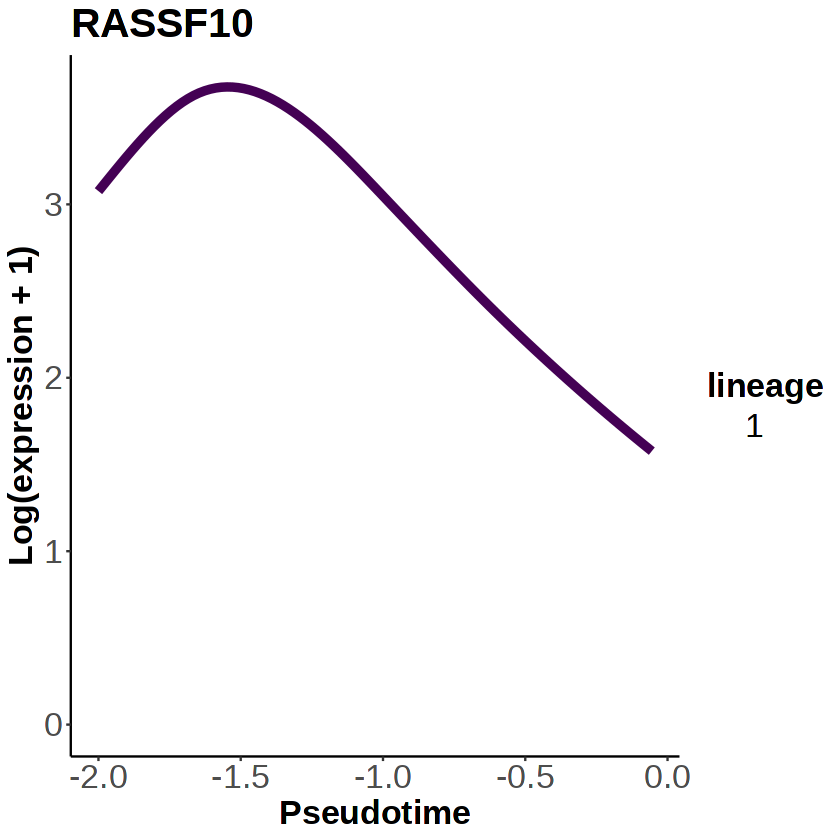

[1] "HOXA9"


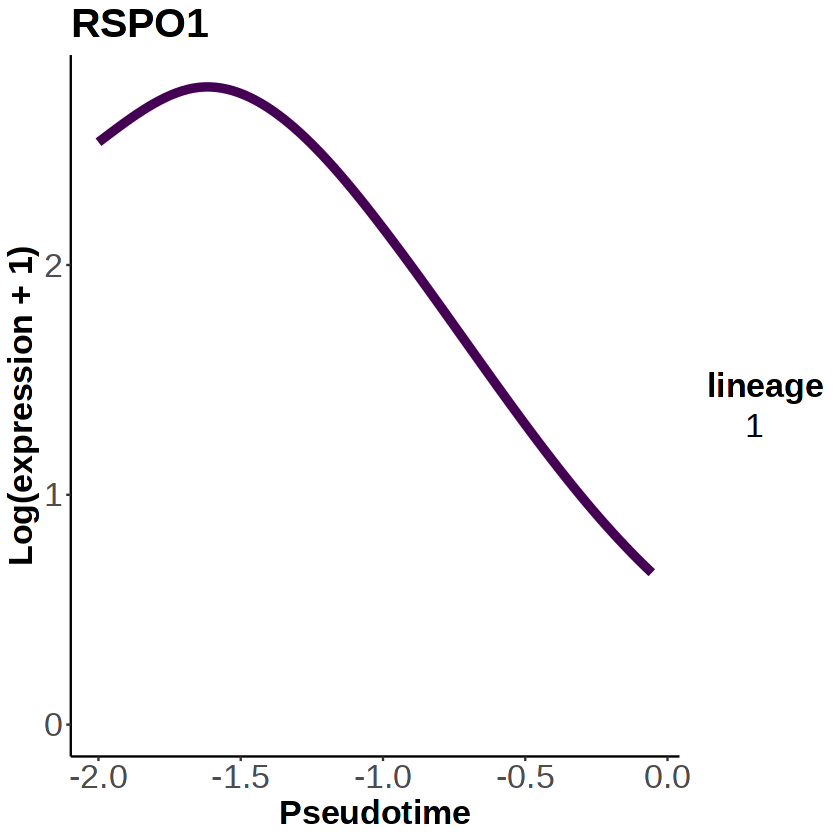

[1] "MSLN"


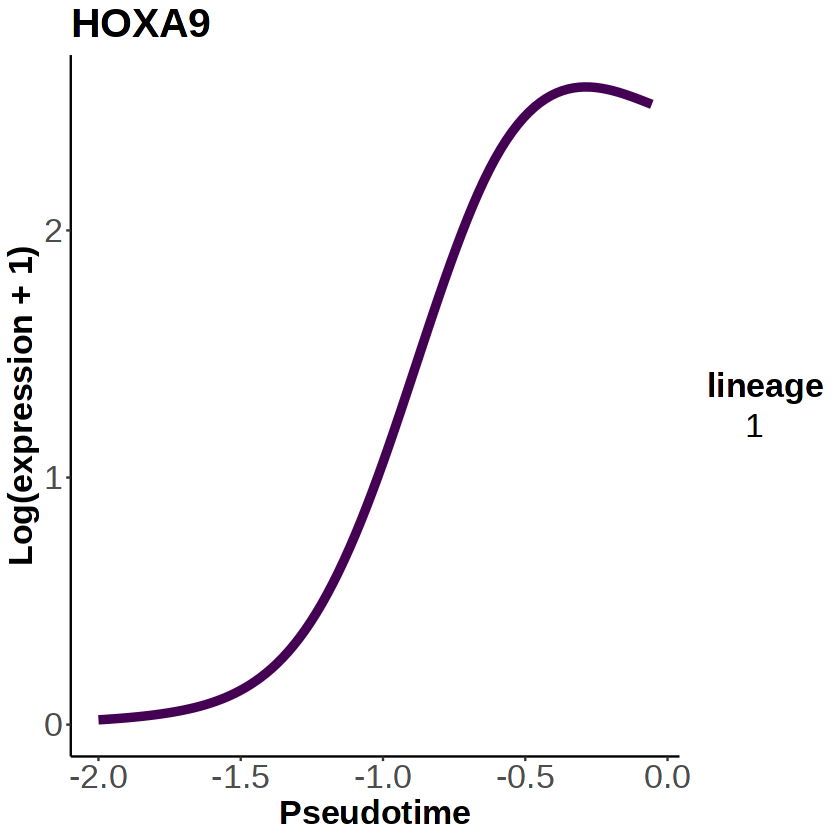

[1] "GATA6"


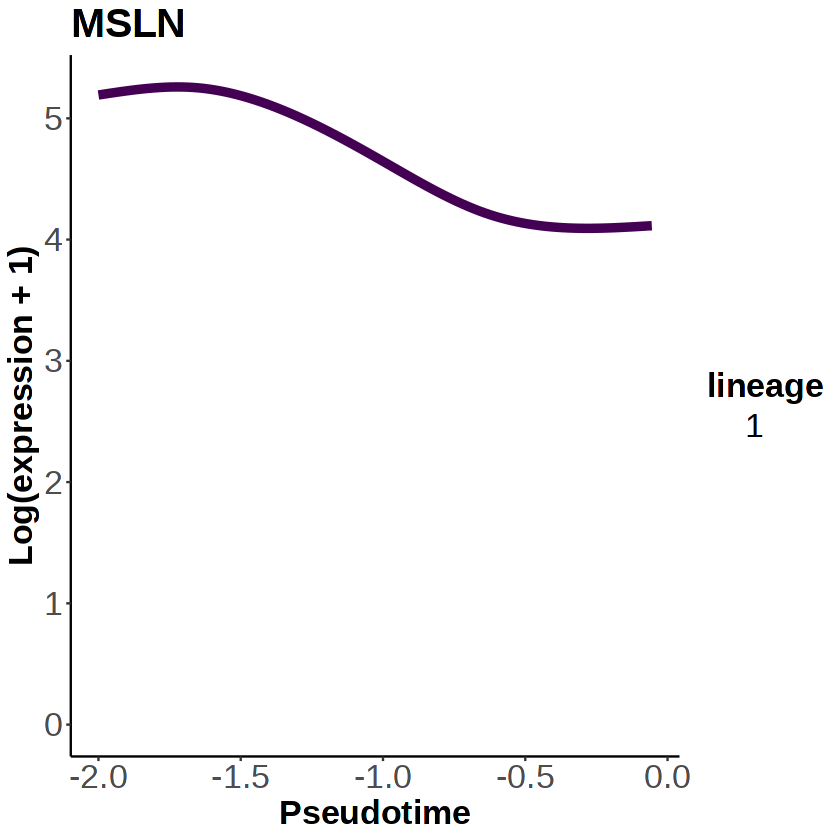

[1] "TSPAN7"


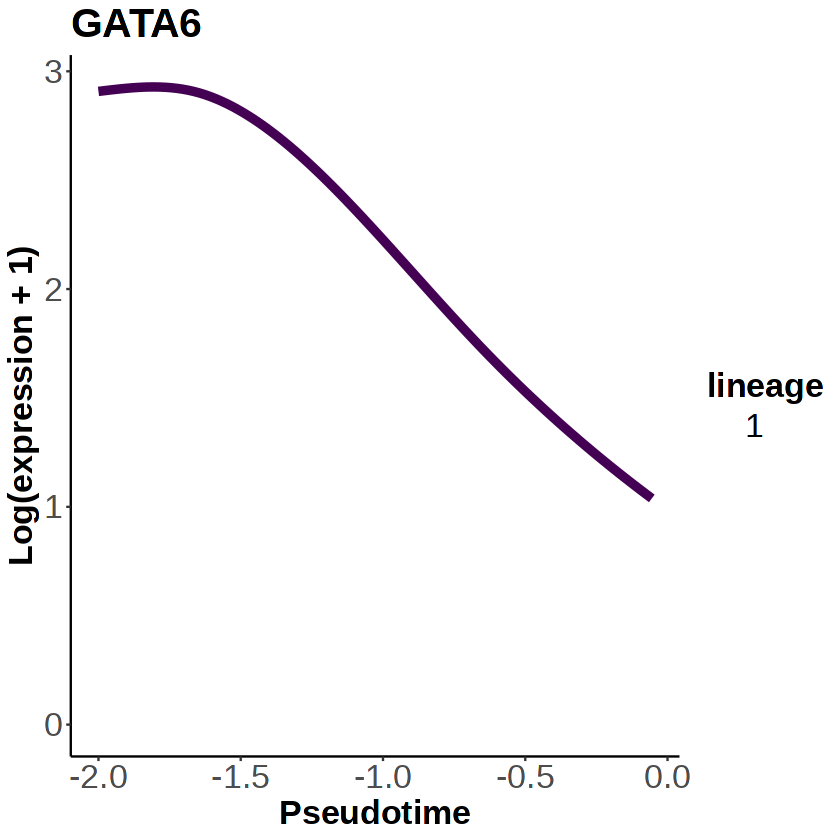

[1] "DOK5"


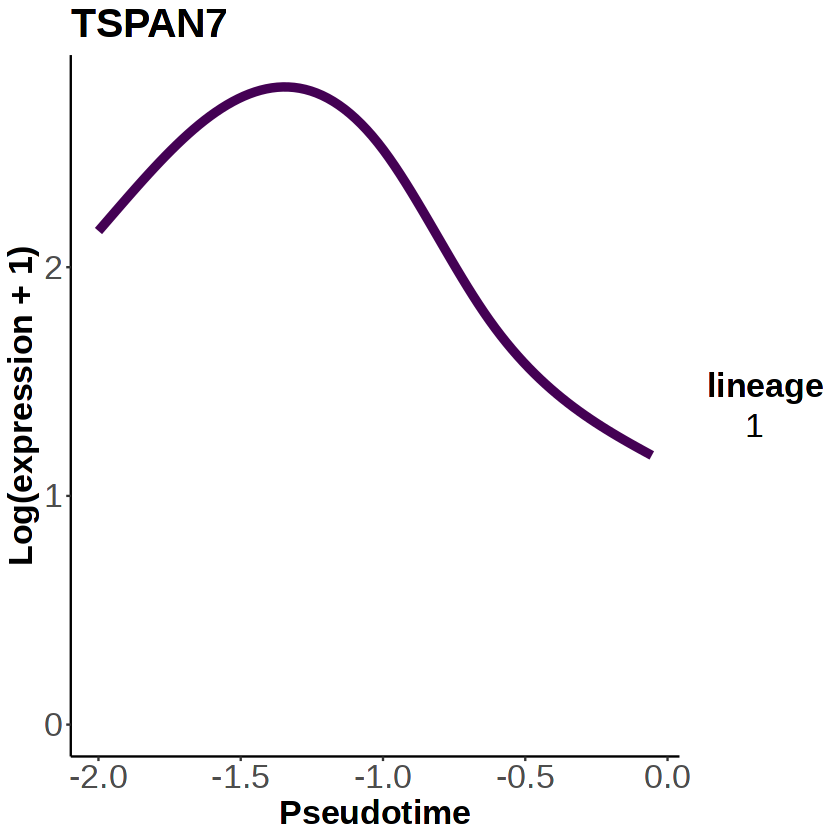

[1] "PROM1"


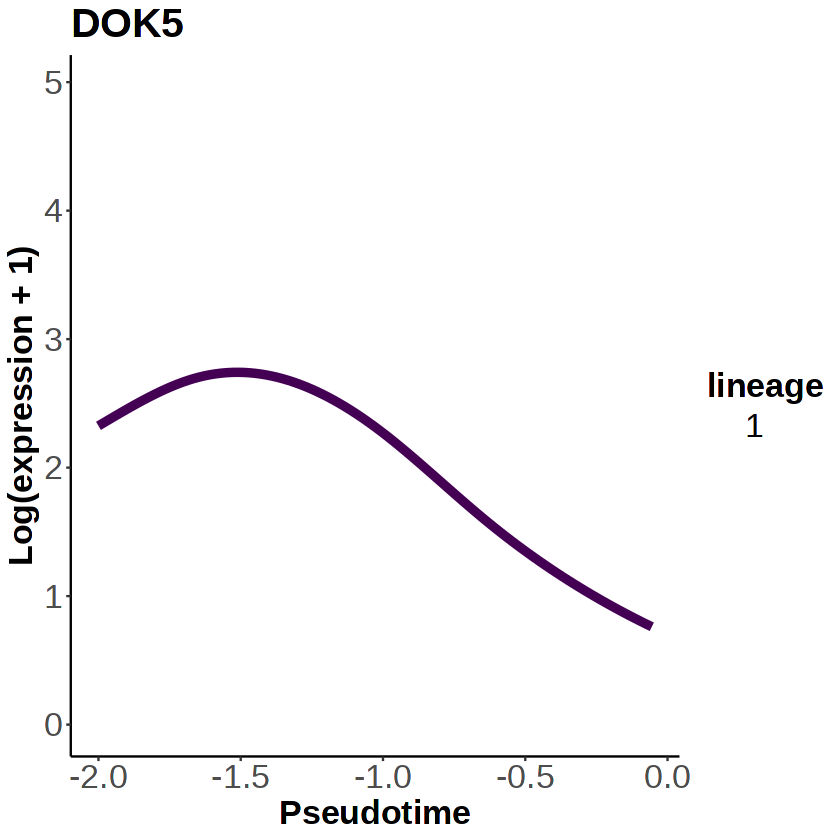

[1] "PPP2R2B"


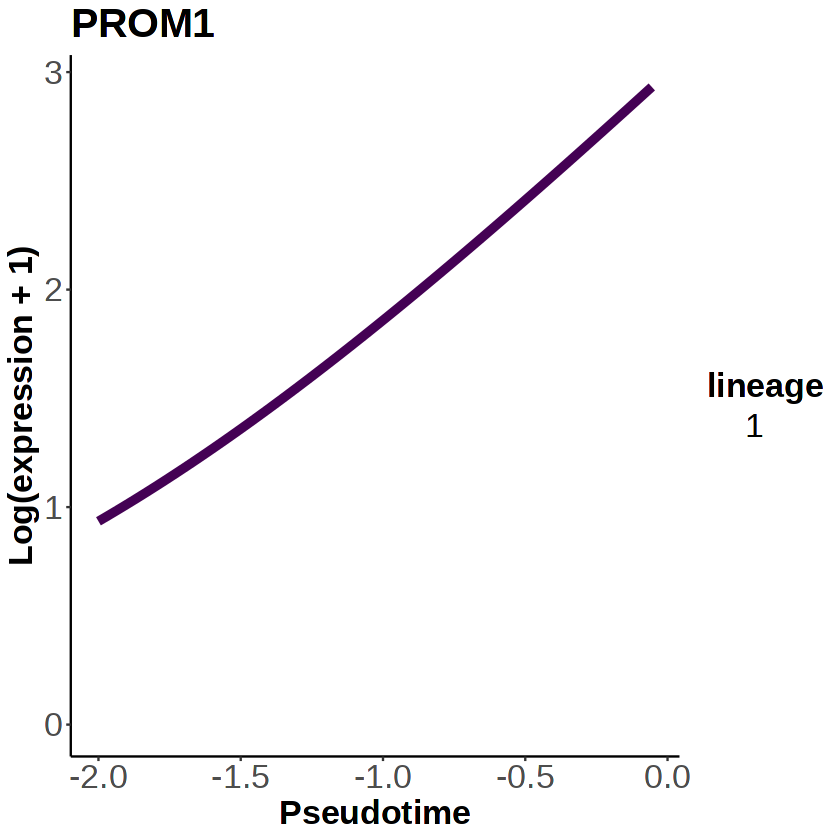

[1] "WT1"


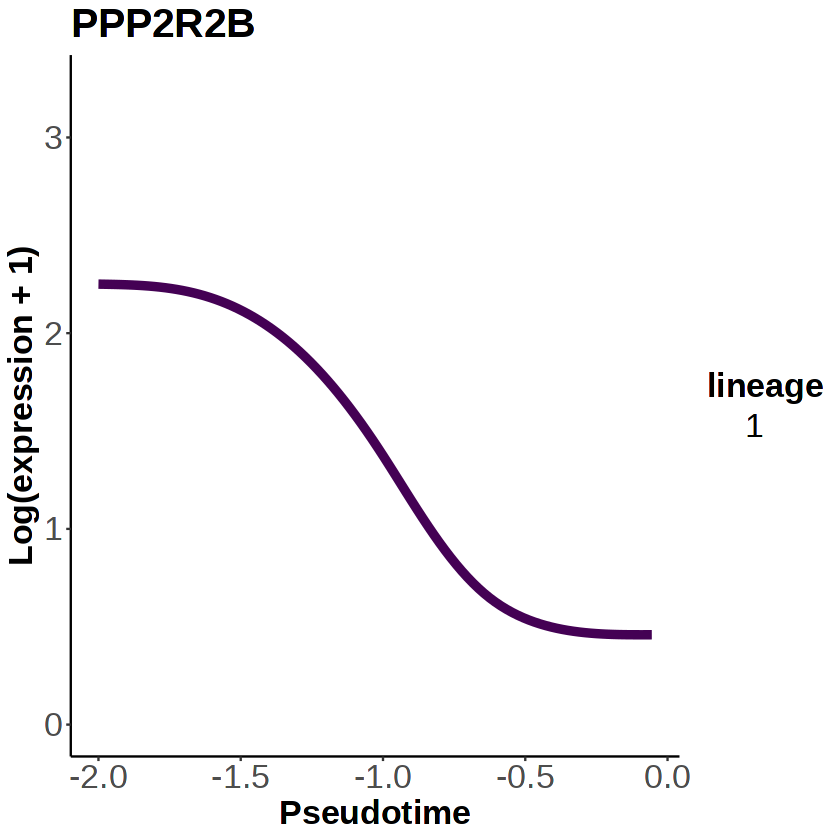

[1] "AIF1L"


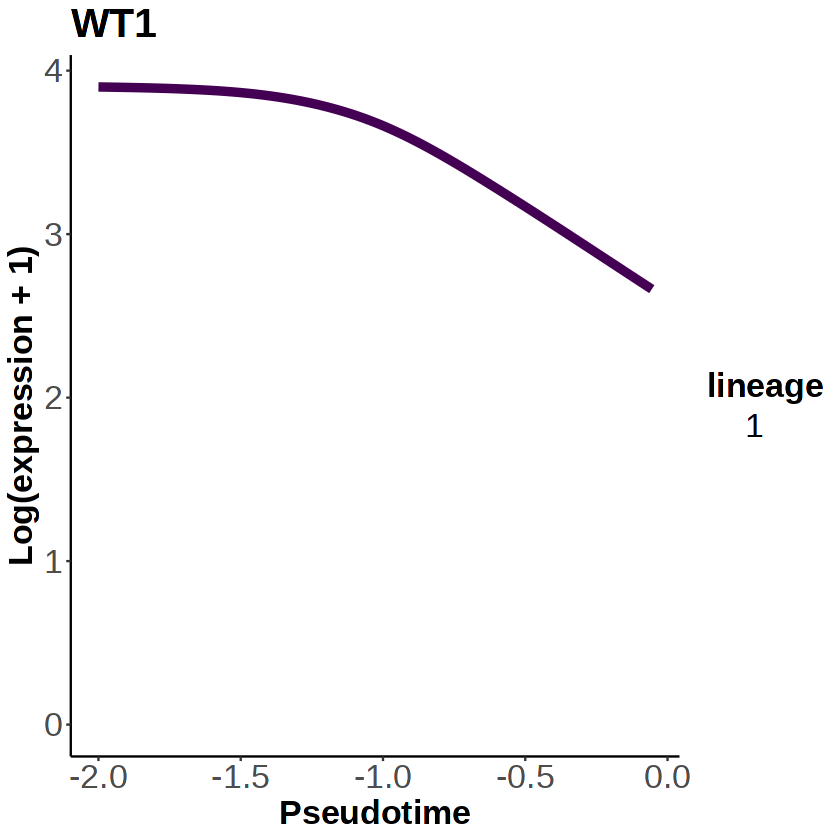

[1] "ARL4C"


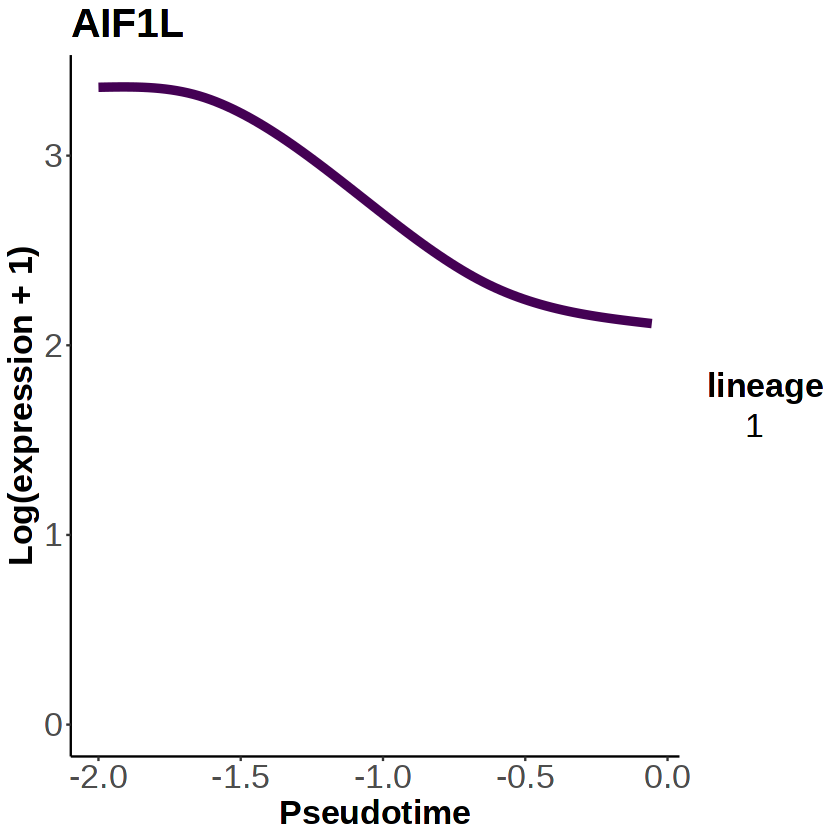

[1] "C19orf33"


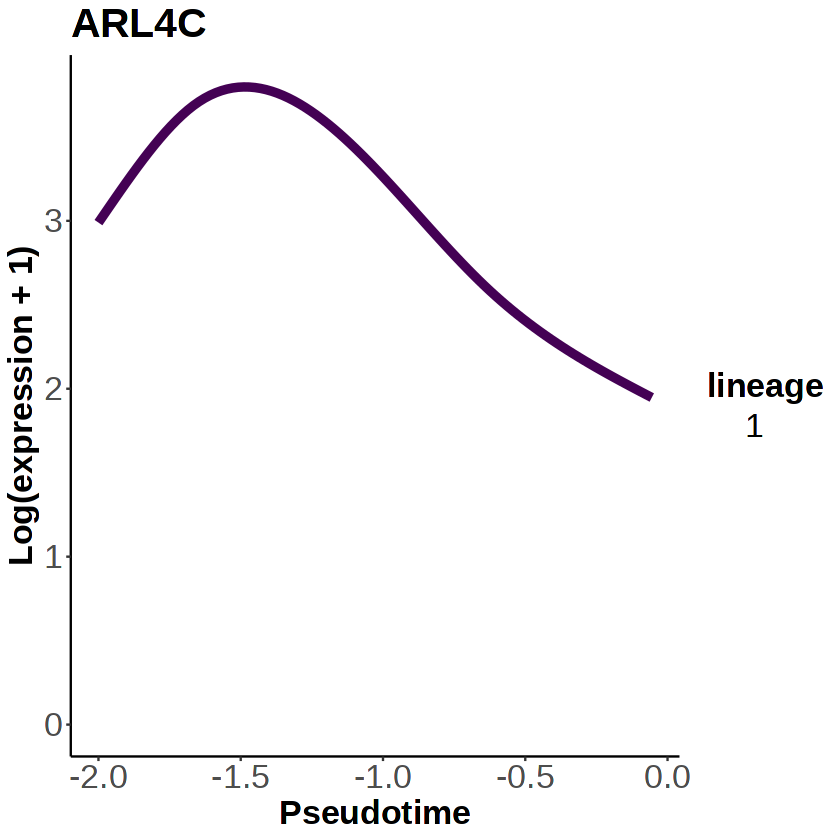

[1] "SERPINE2"


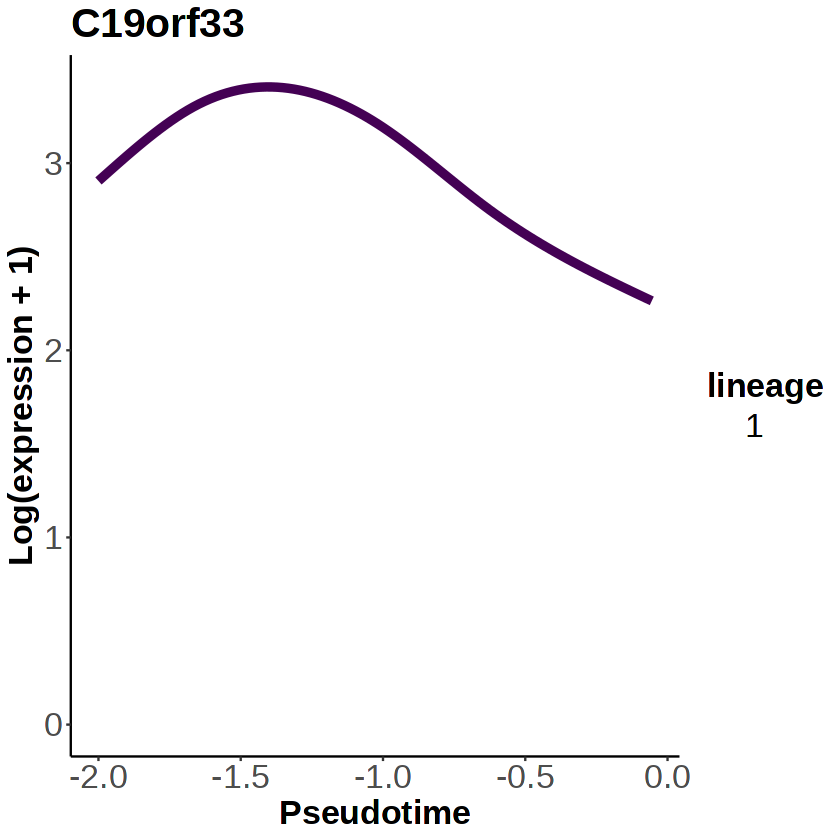

[1] "ASS1"


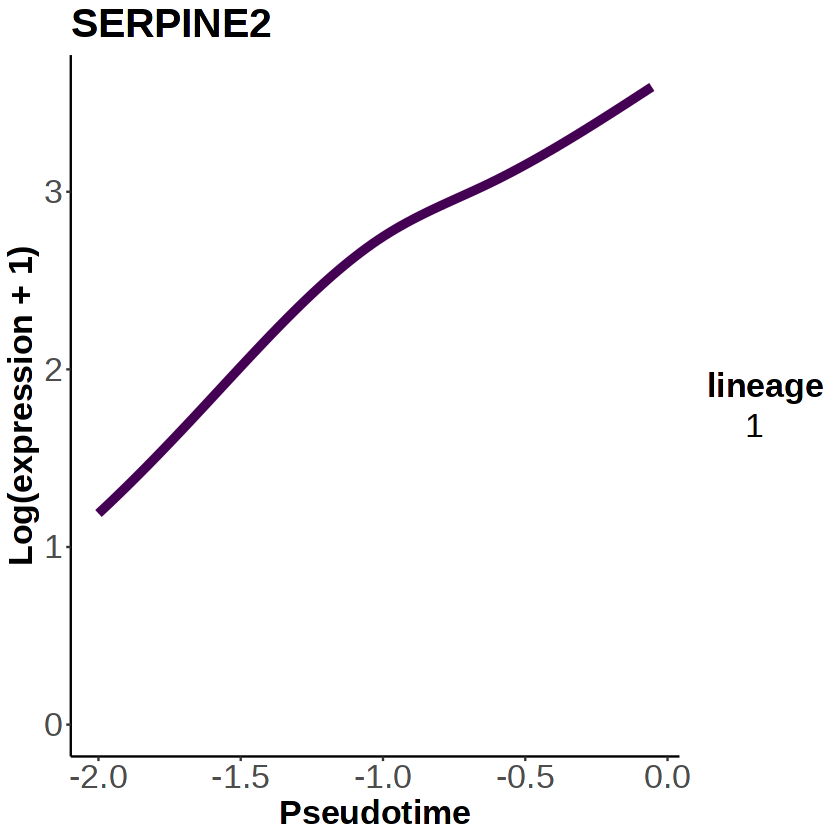

[1] "AFAP1L2"


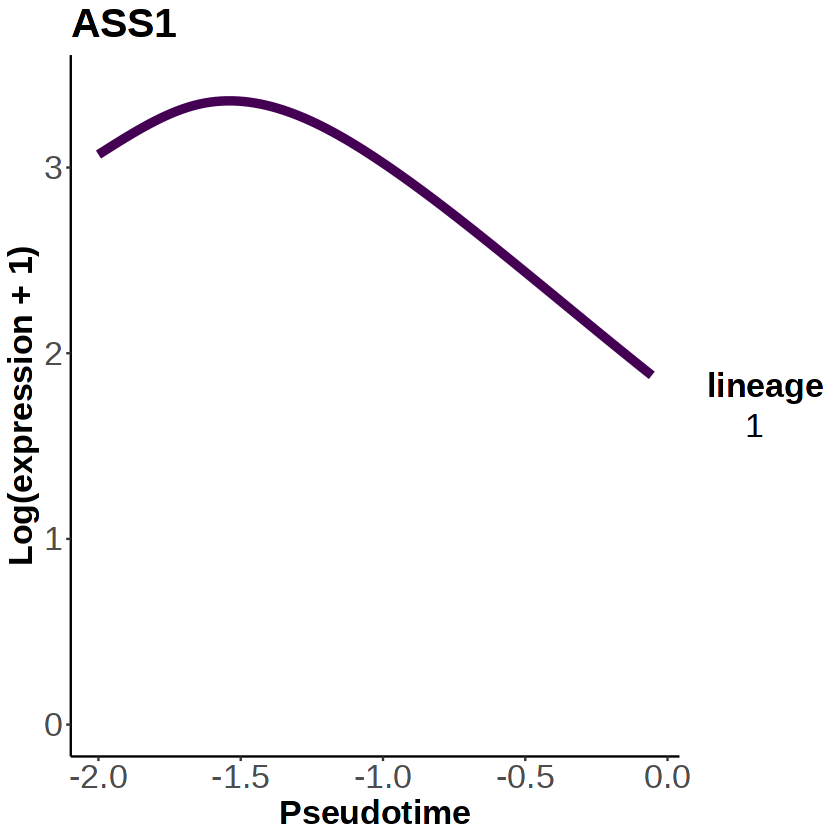

[1] "RANGRF"


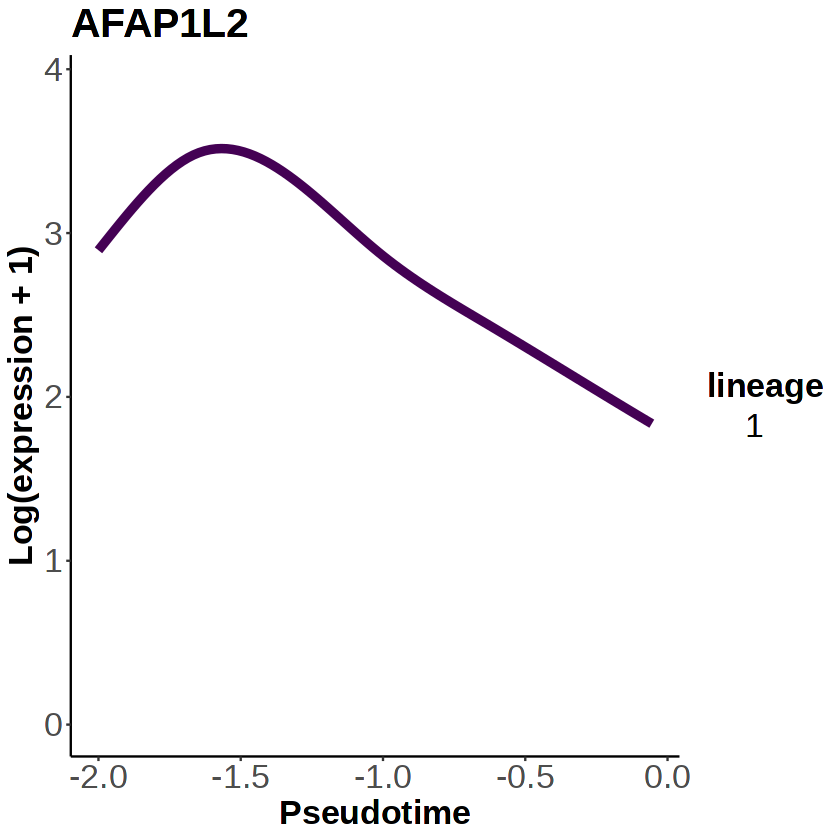

[1] "WNT10A"


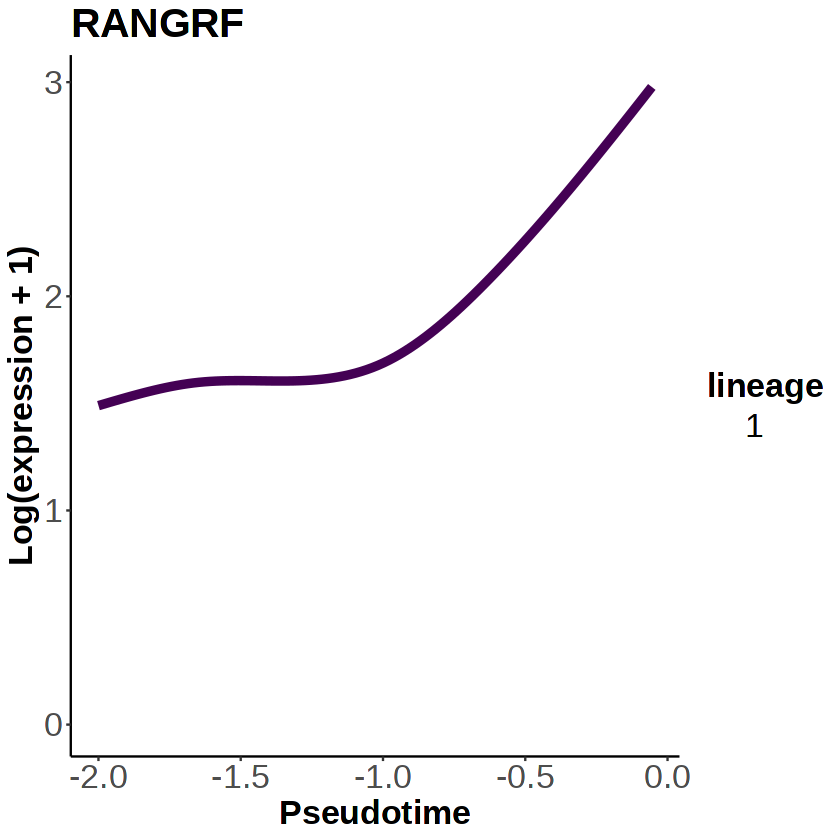

[1] "LRIG1"


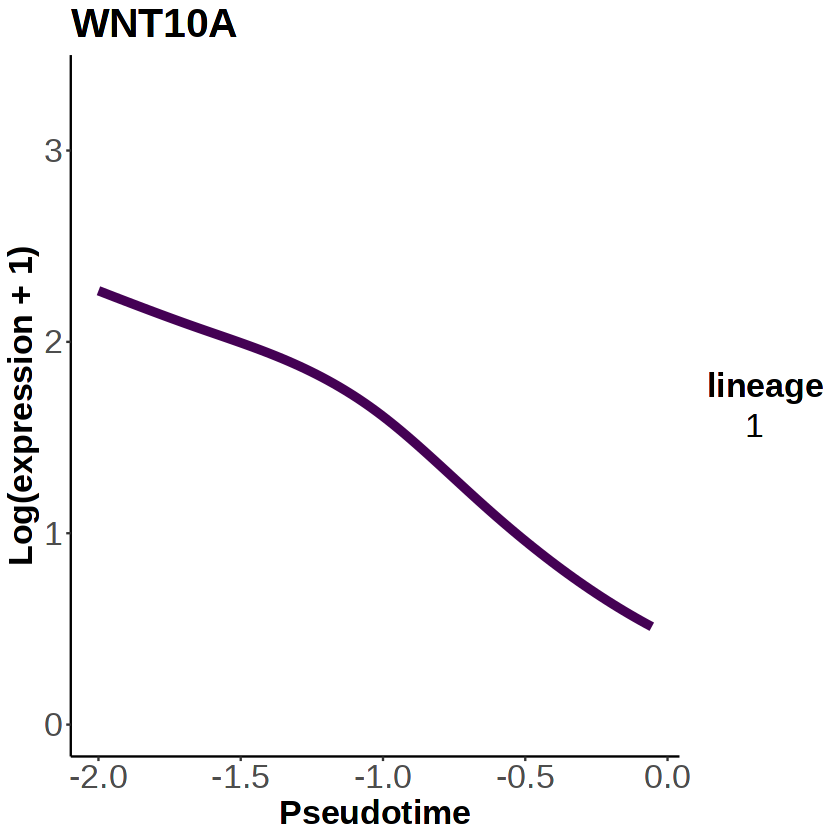

[1] "EGR1"


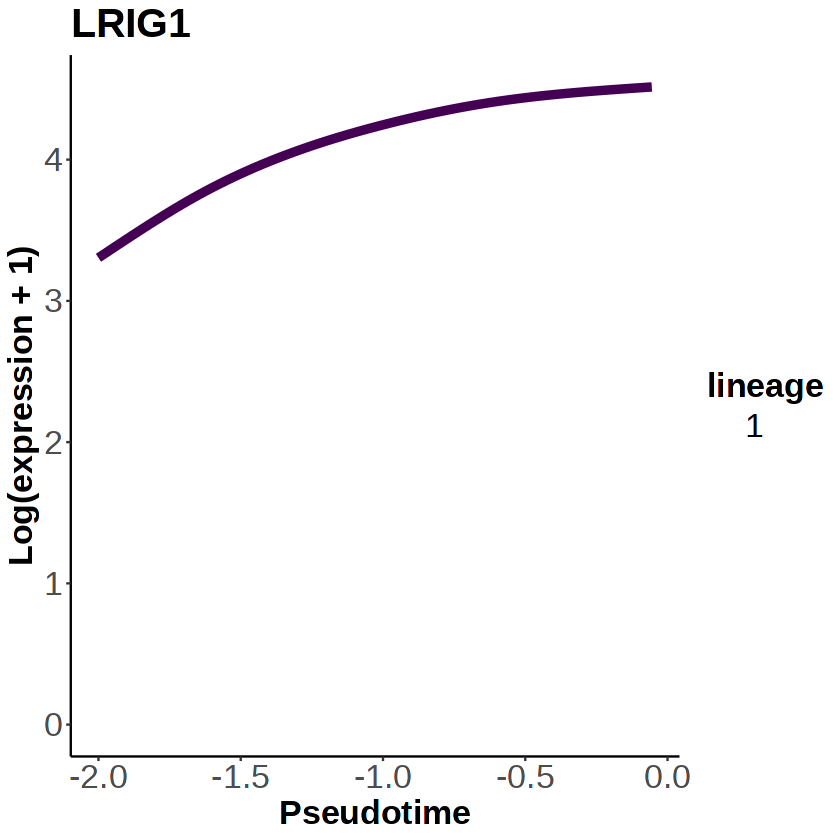

[1] "UPK3B"


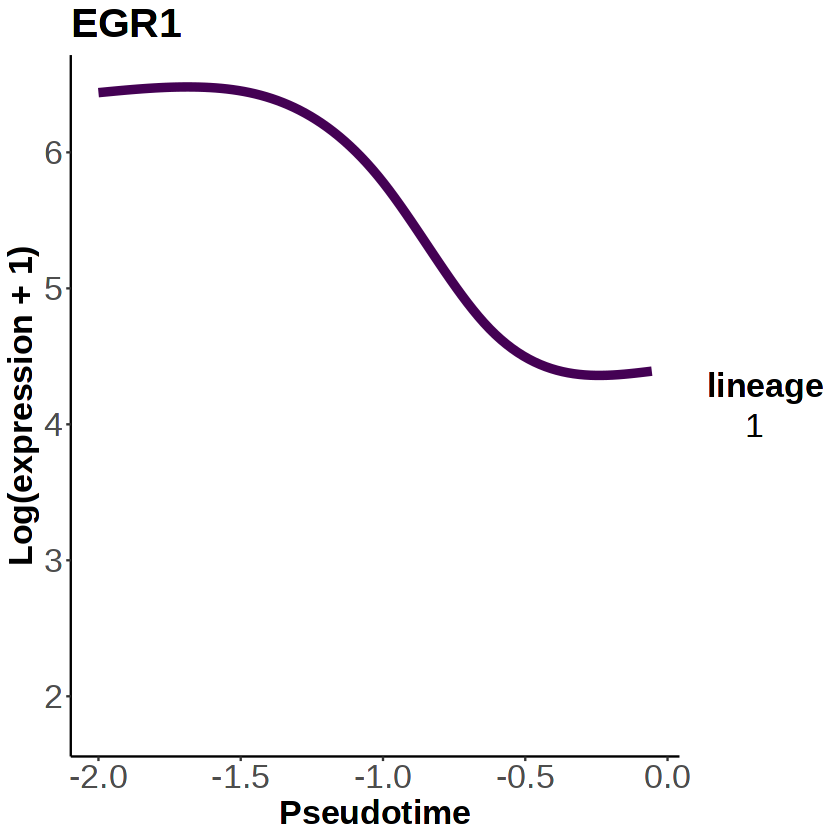

[1] "CRTAC1"


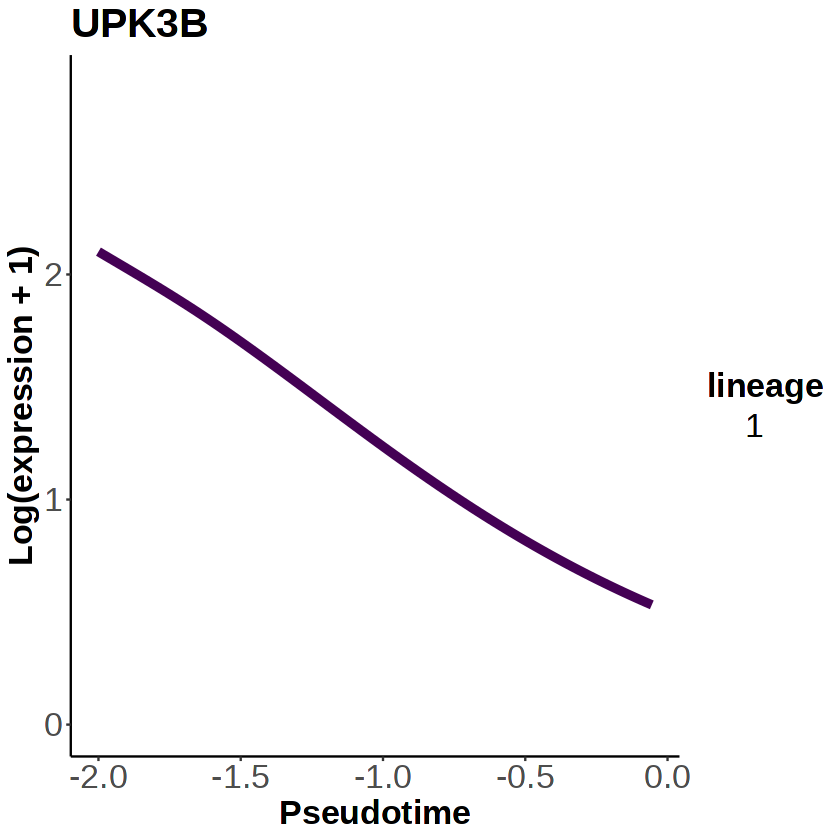

[1] "CKB"


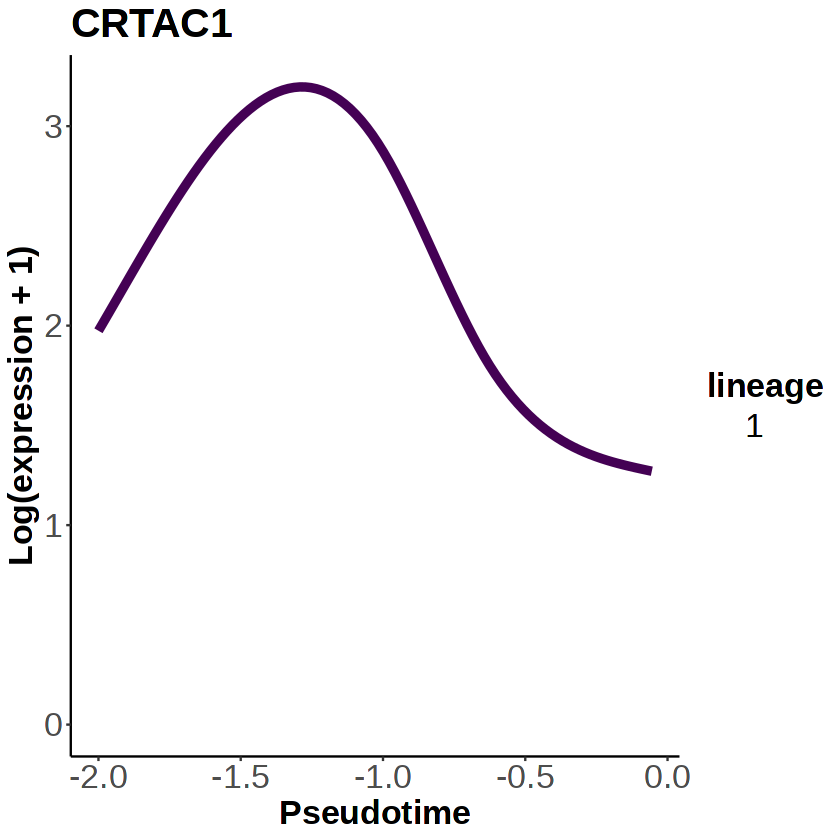

[1] "DLGAP1"


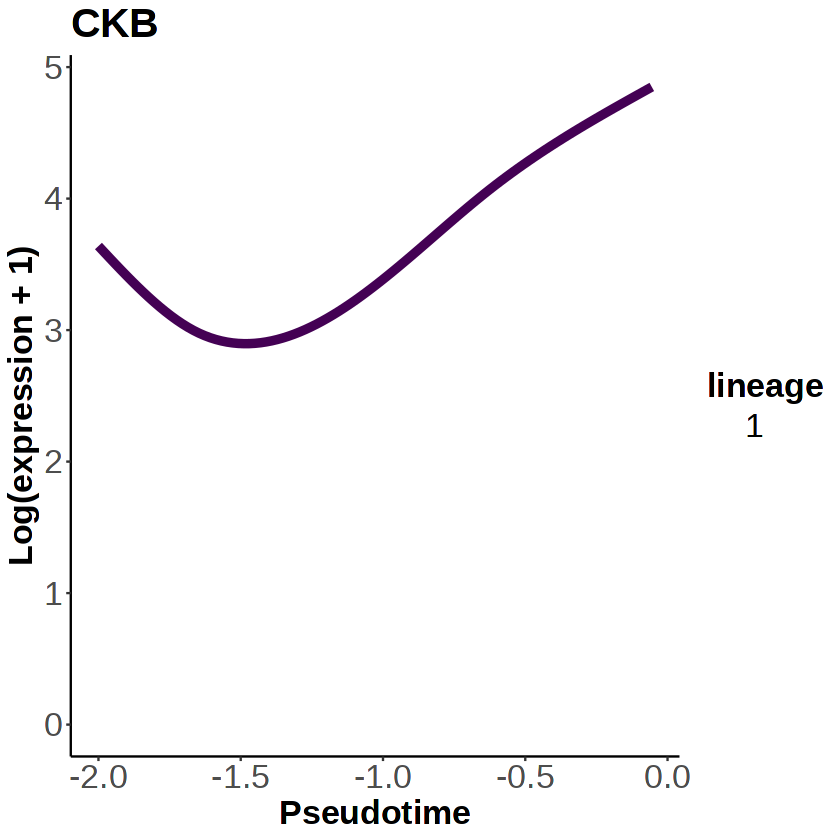

[1] "TMEM101"


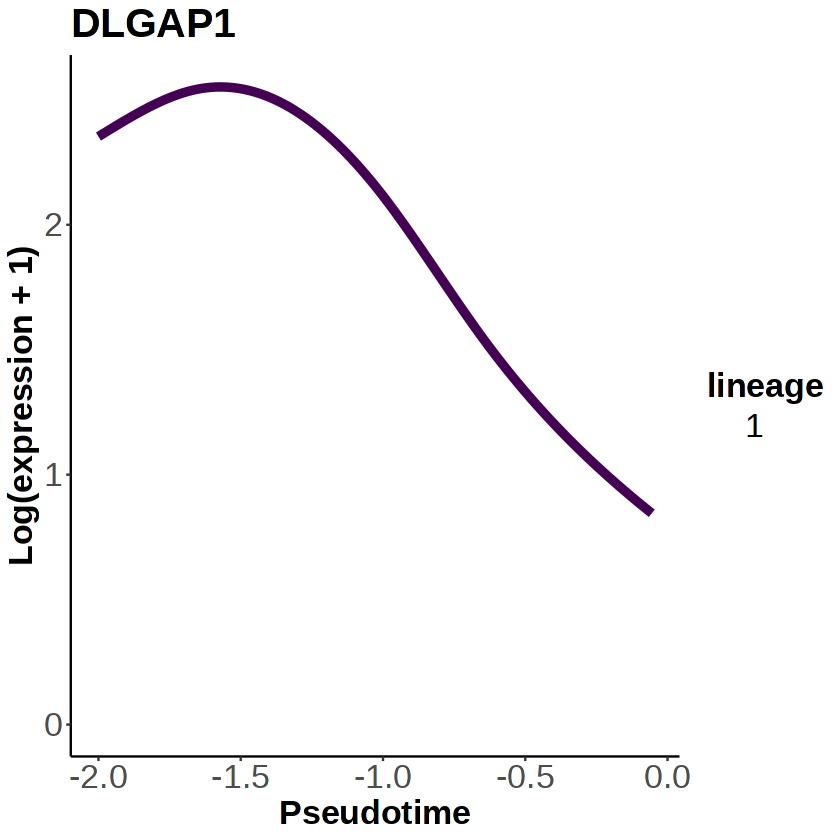

[1] "TNFRSF12A"


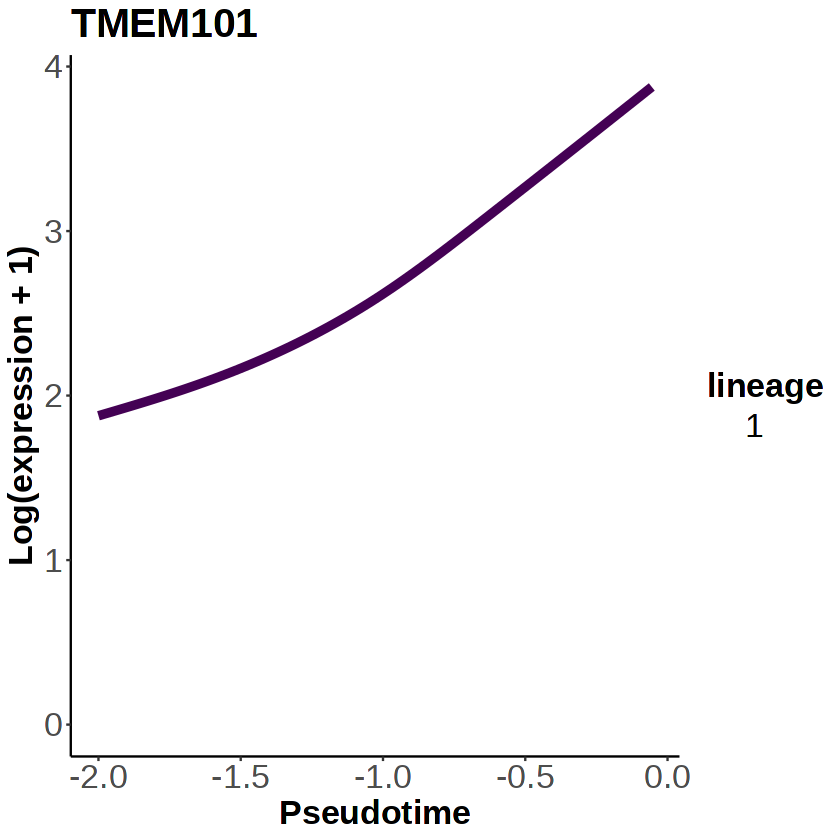

[1] "ADAM28"


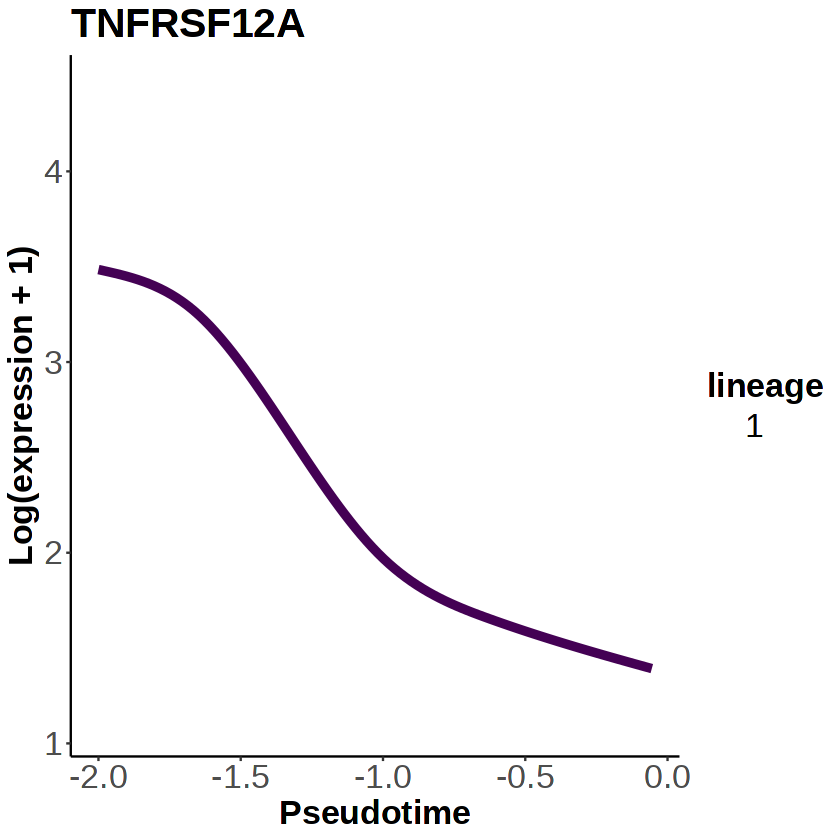

[1] "GALNT17"


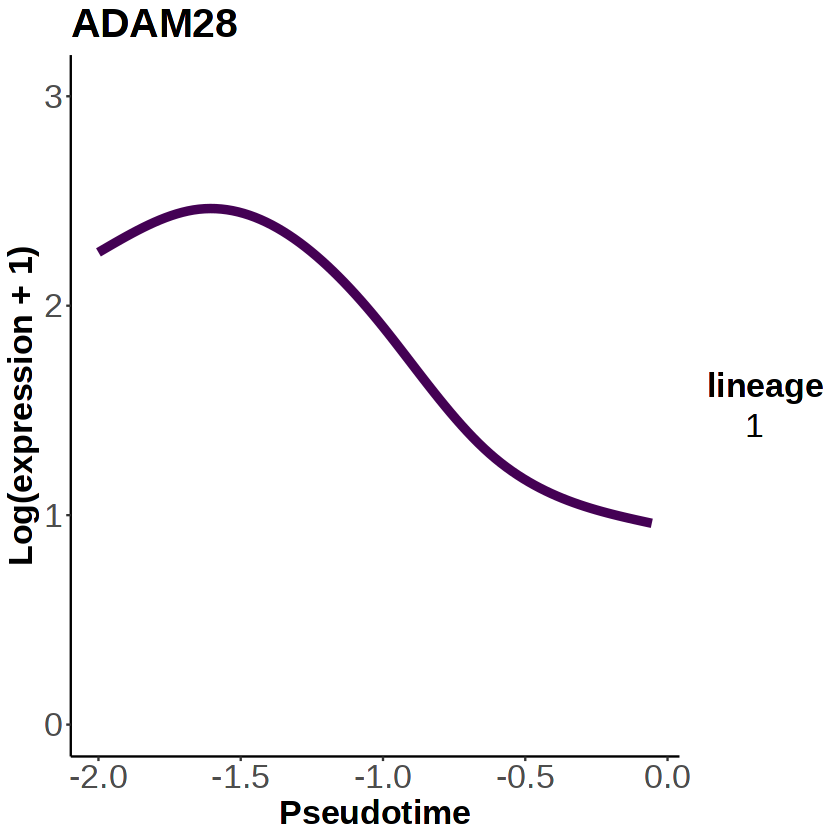

[1] "MMP28"


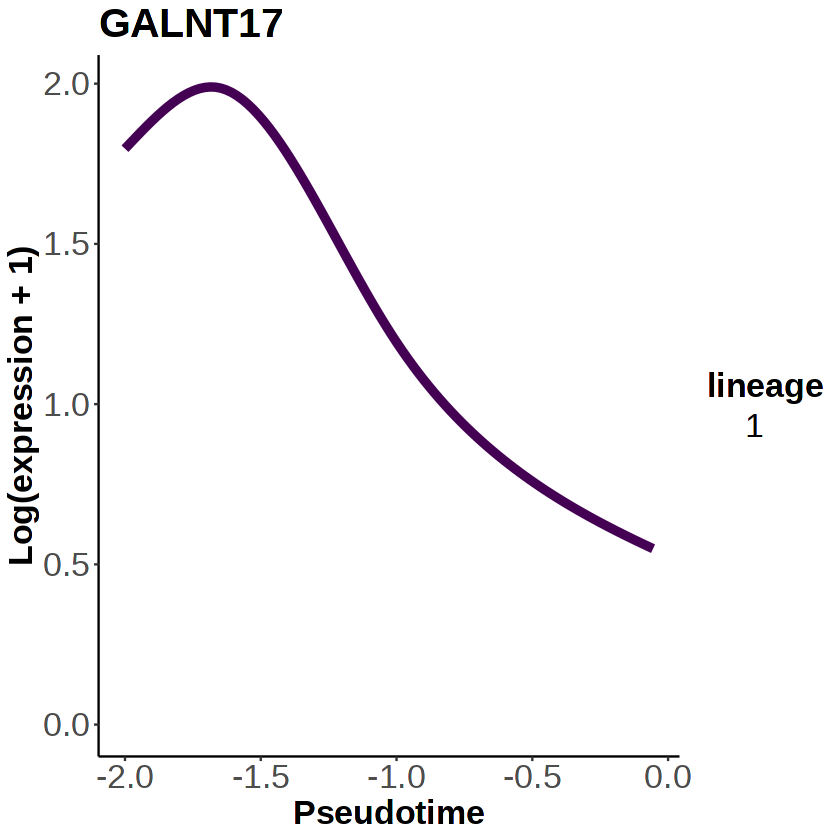

[1] "ADAMTS1"


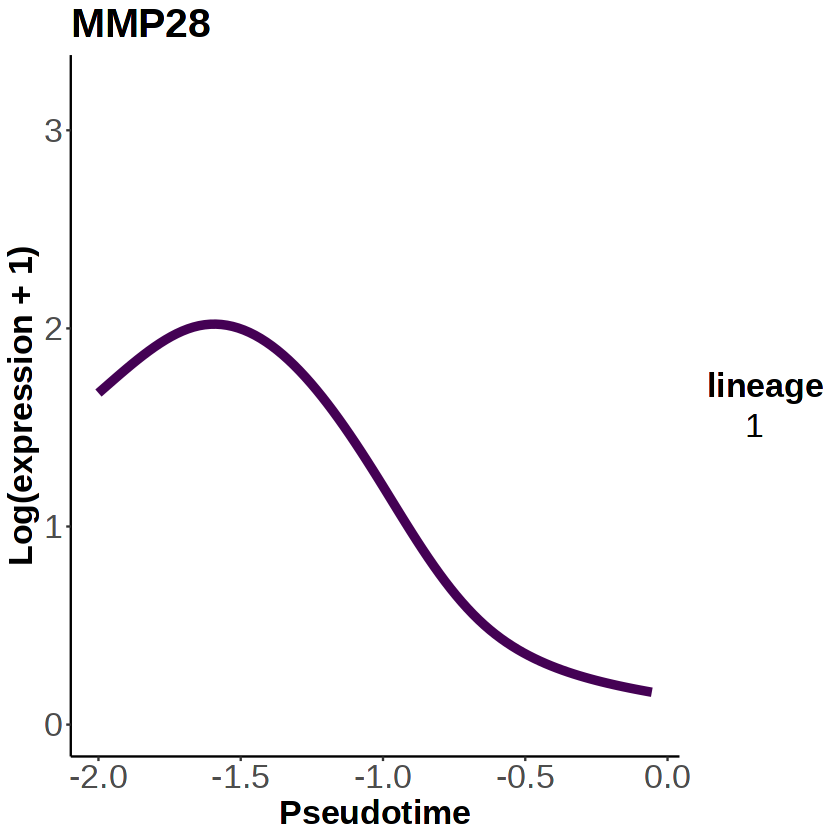

[1] "ACTG2"


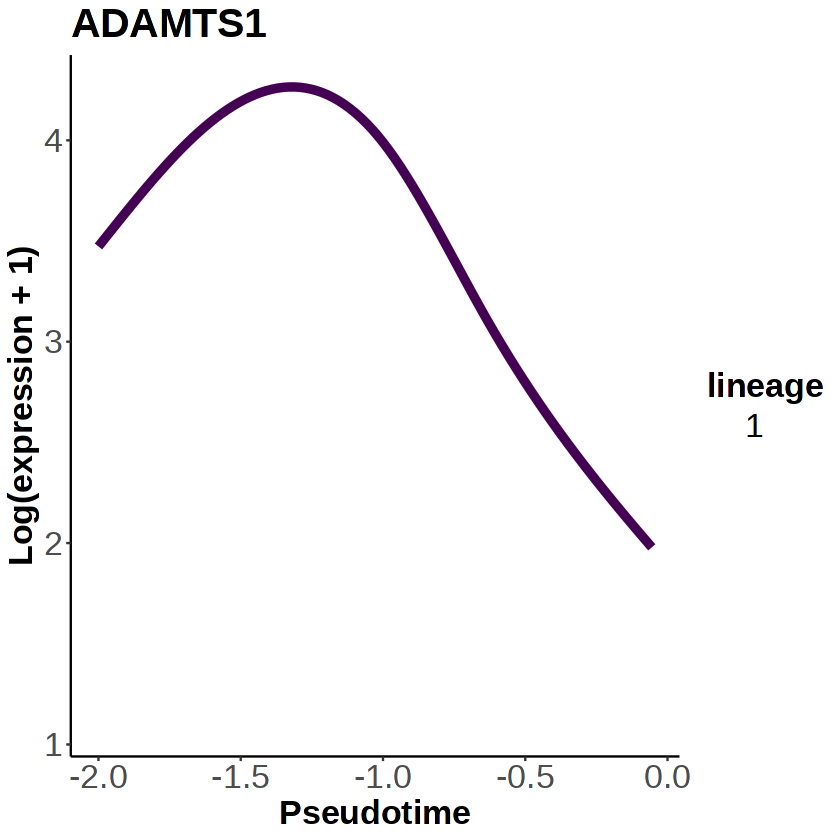

[1] "ACTA2"


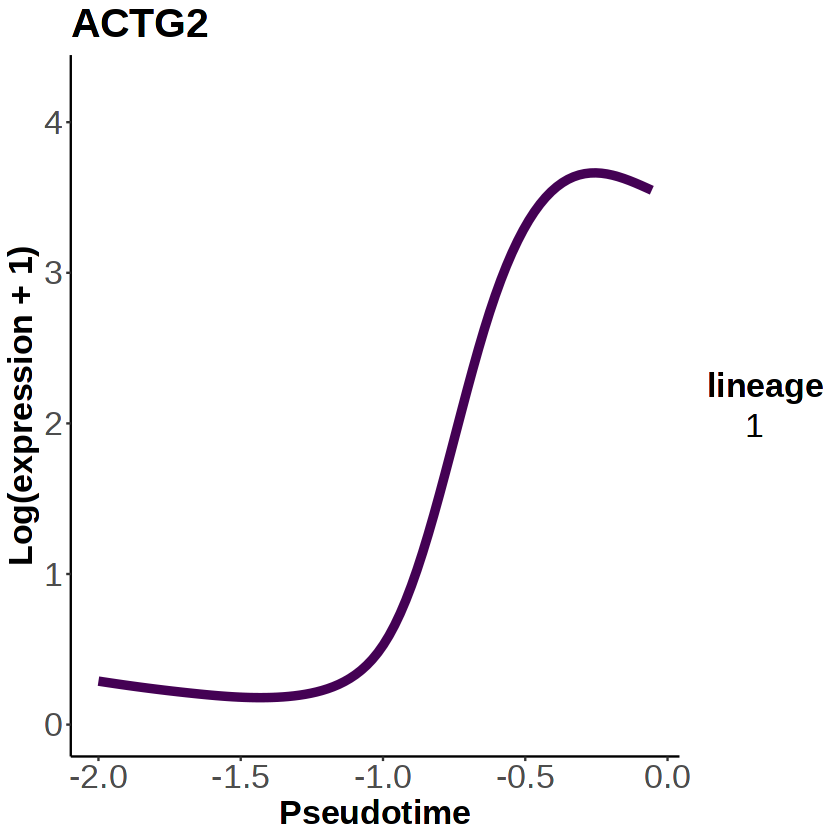

[1] "ALDH1A2"


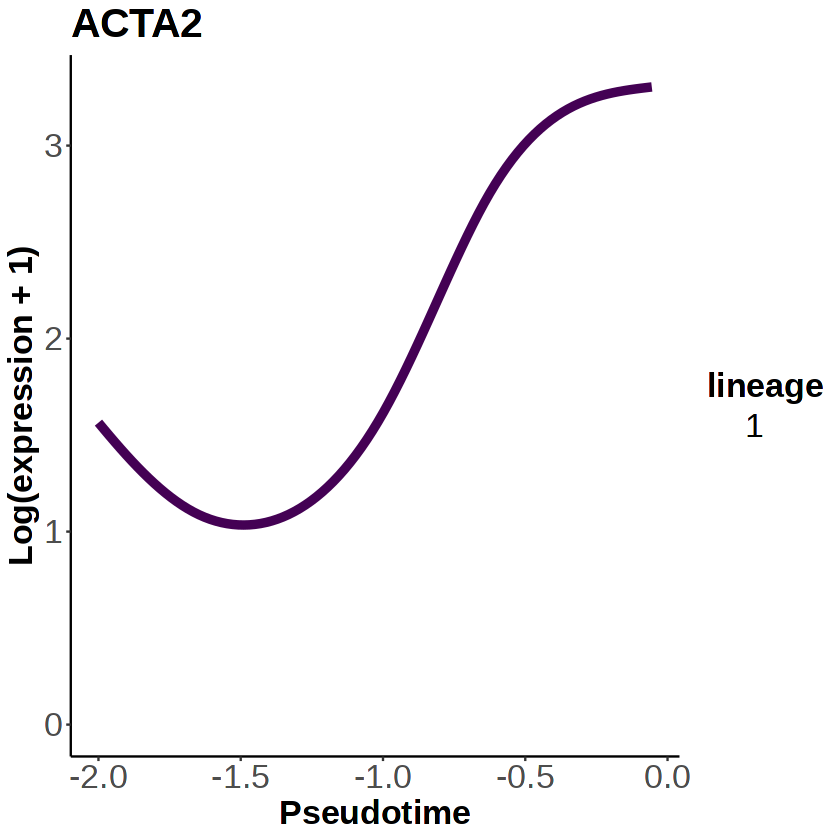

[1] "TUBB2B"


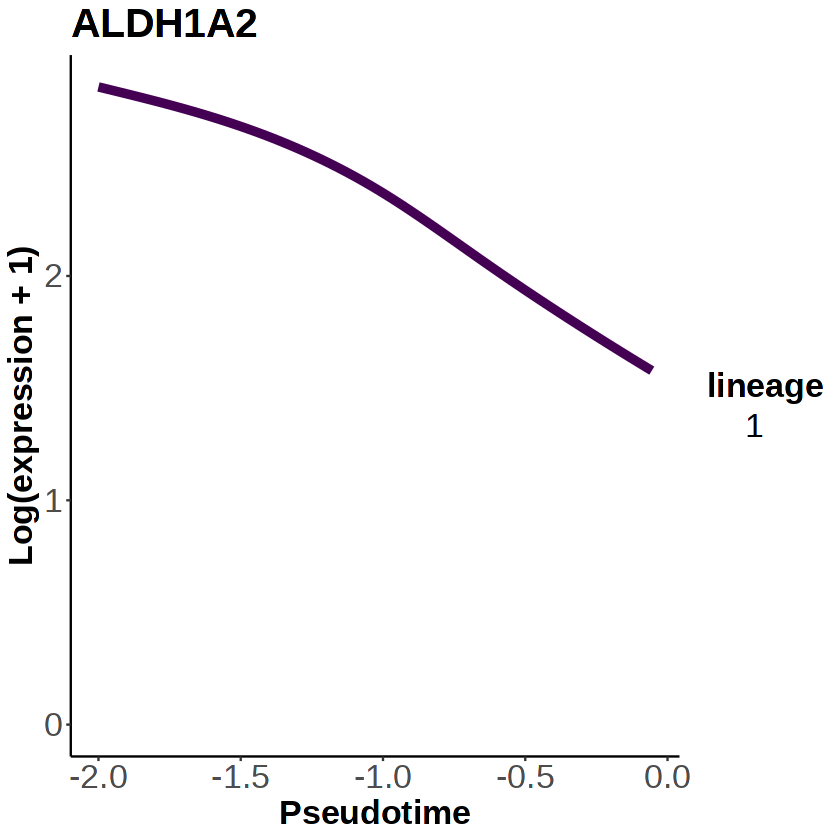

[1] "CD109"


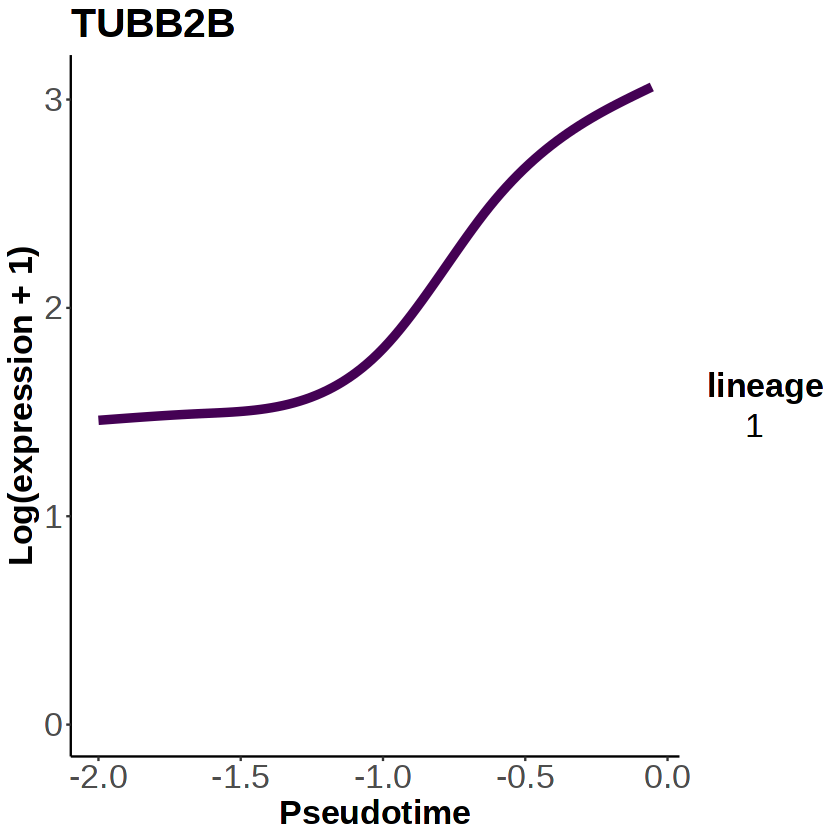

[1] "MYLK"


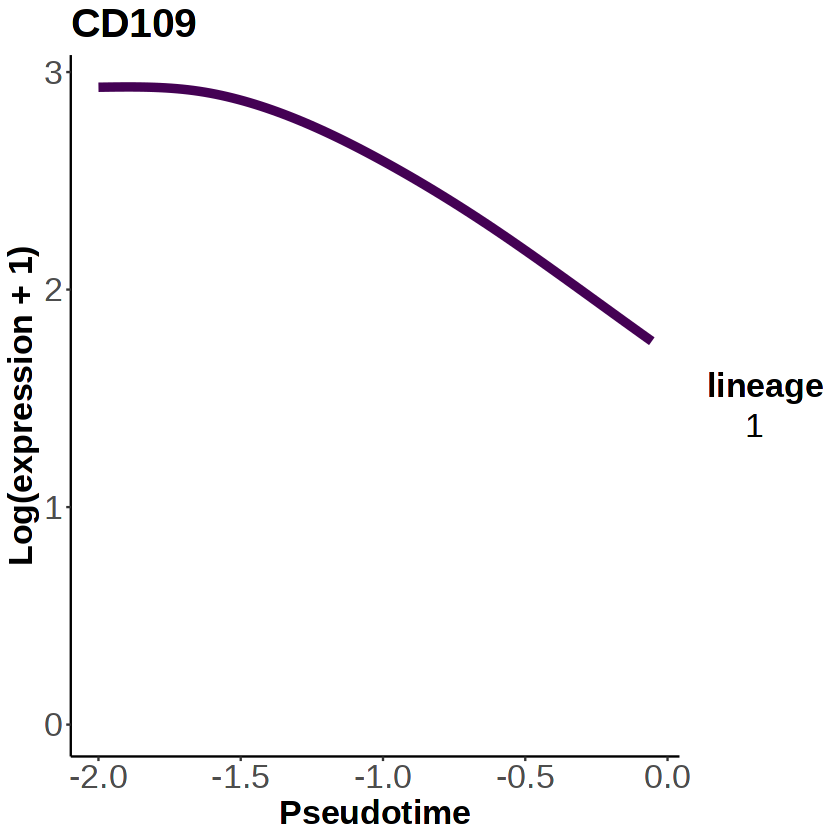

[1] "AAK1"


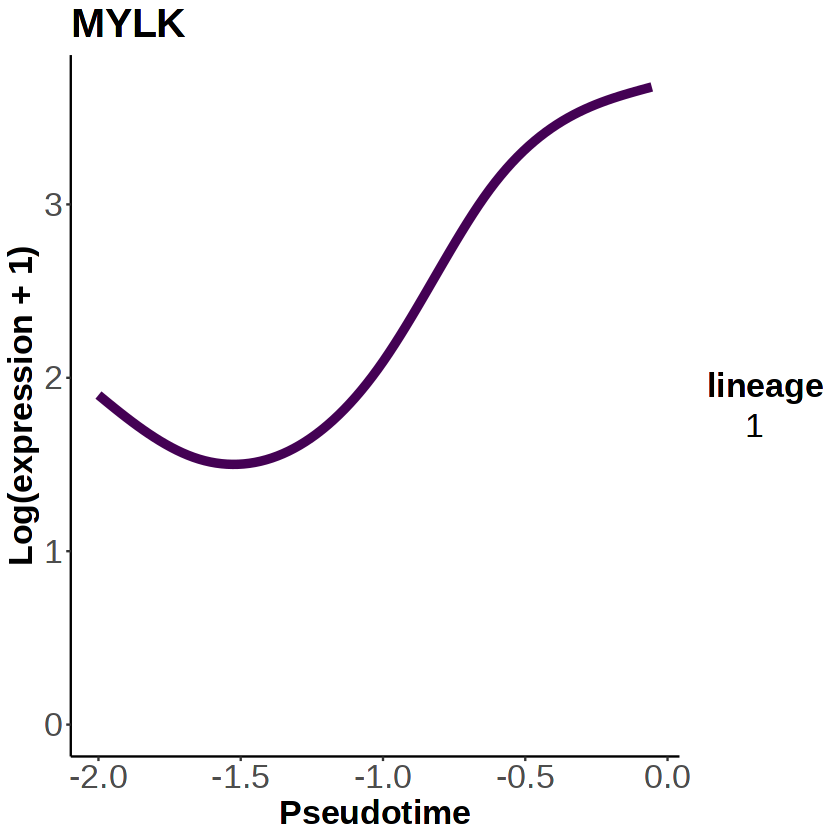

[1] "IGFBP7"


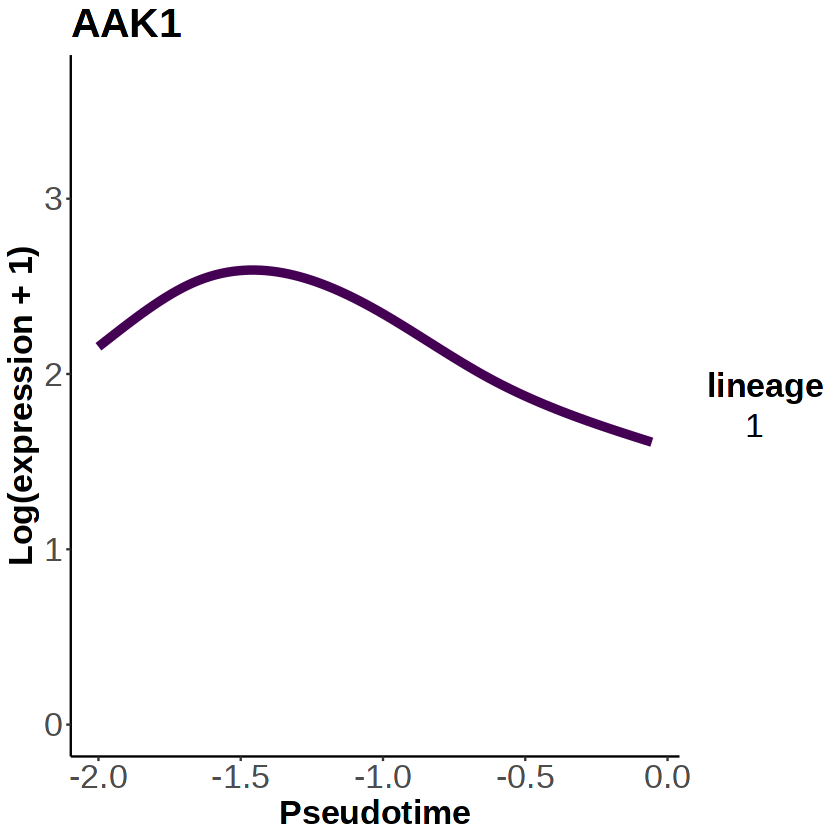

[1] "EFNB2"


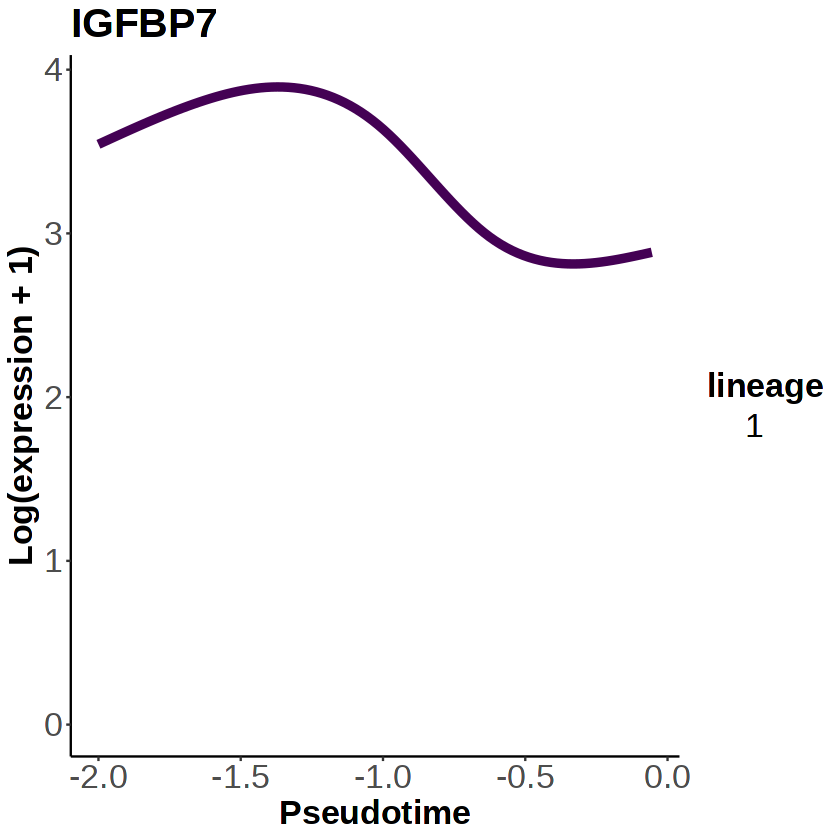

[1] "ADCY5"


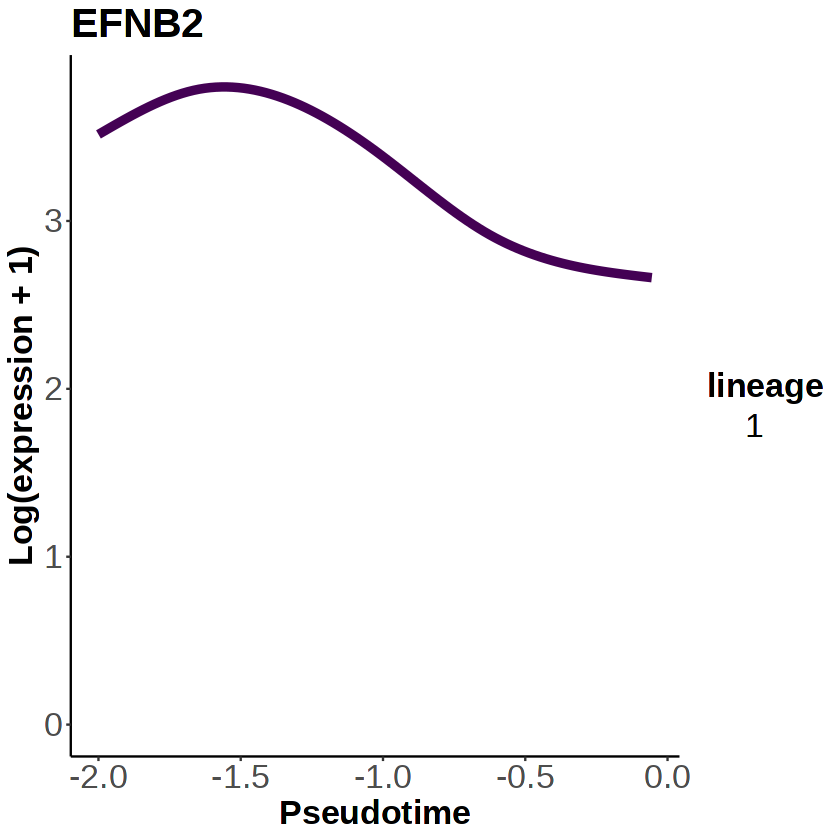

[1] "COL23A1"


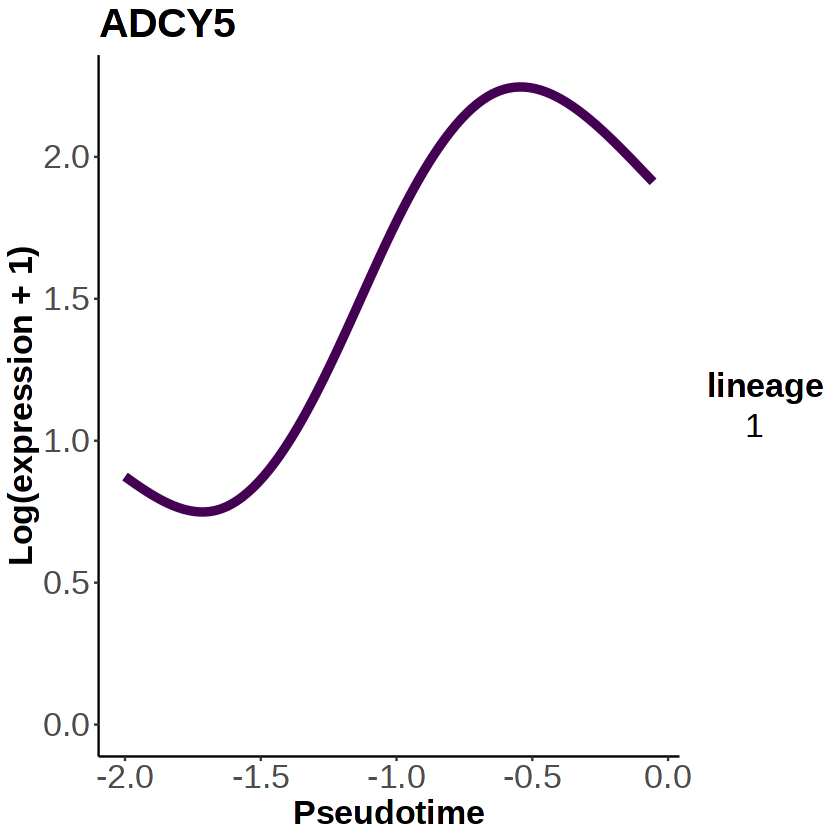

[1] "SORL1"


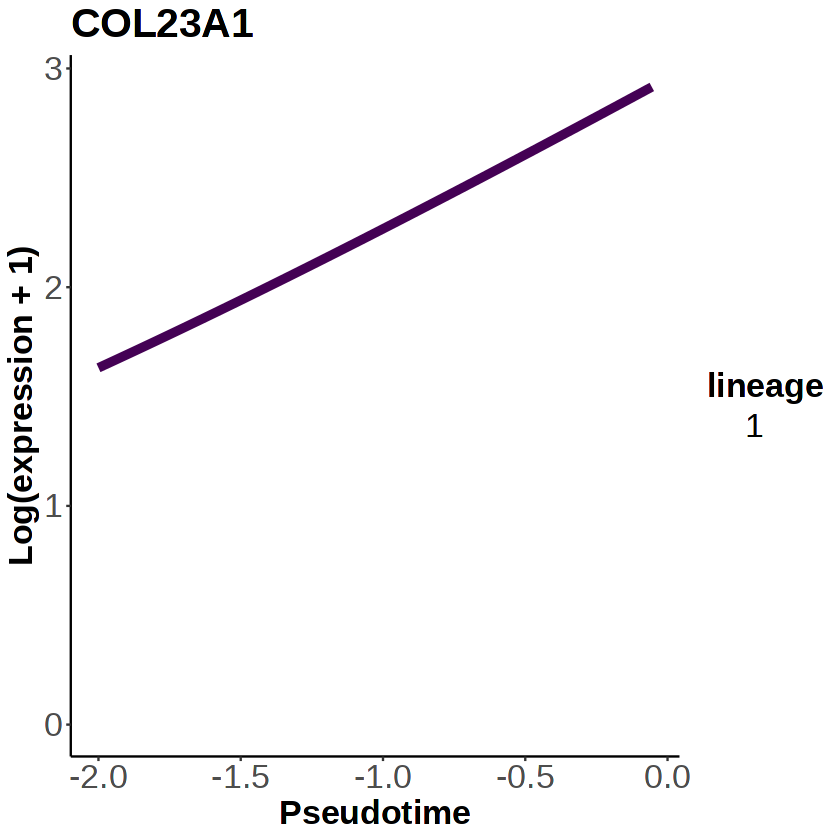

[1] "ARHGEF19"


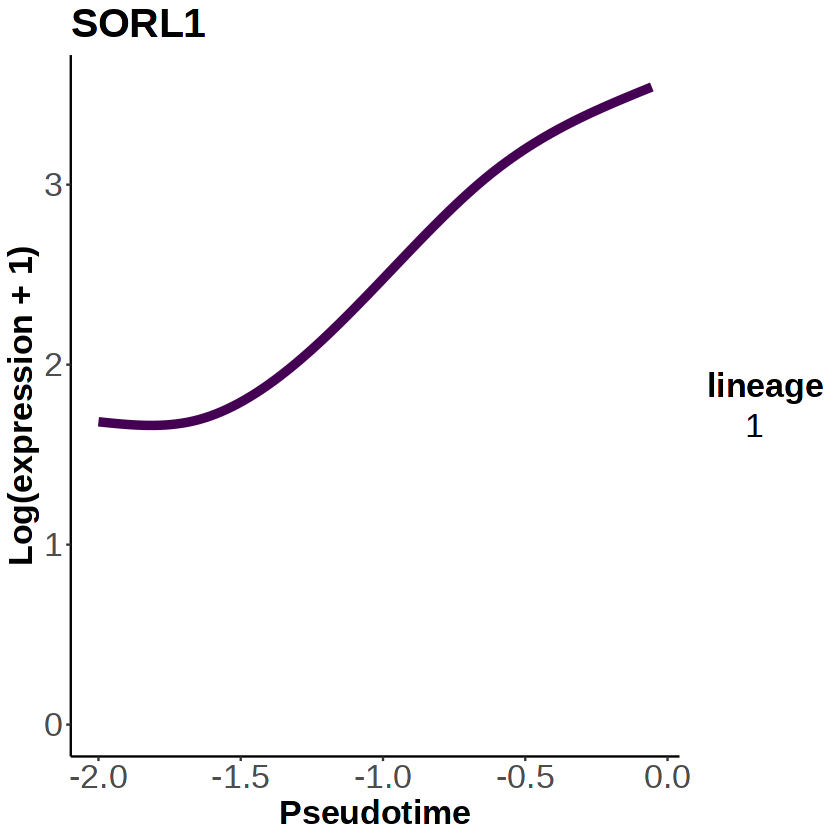

[1] "SYNE2"


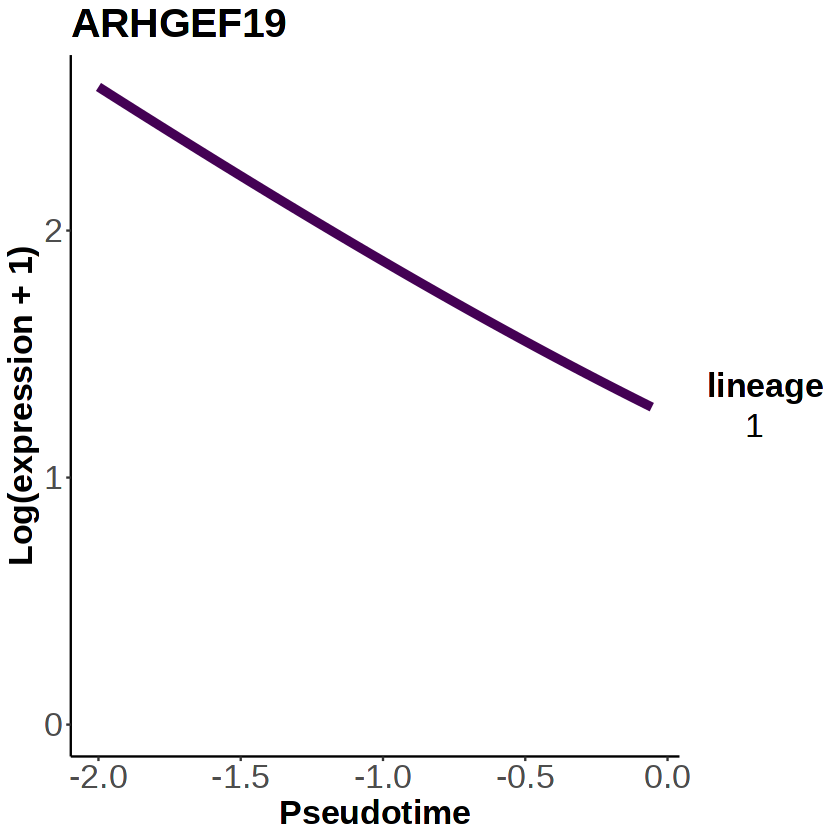

[1] "MYH11"


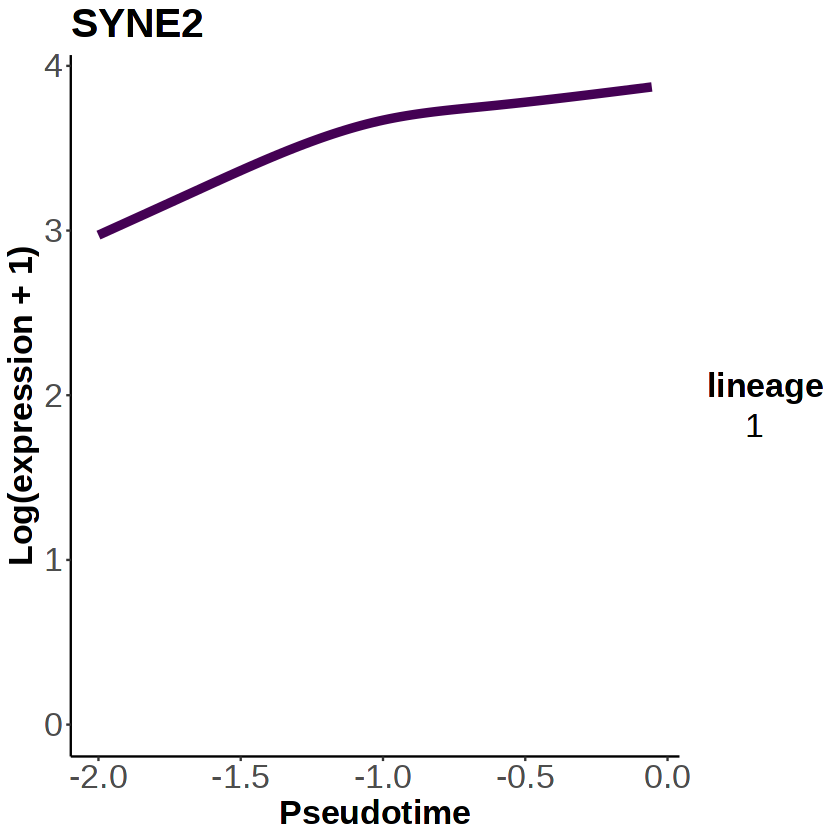

[1] "PCDH1"


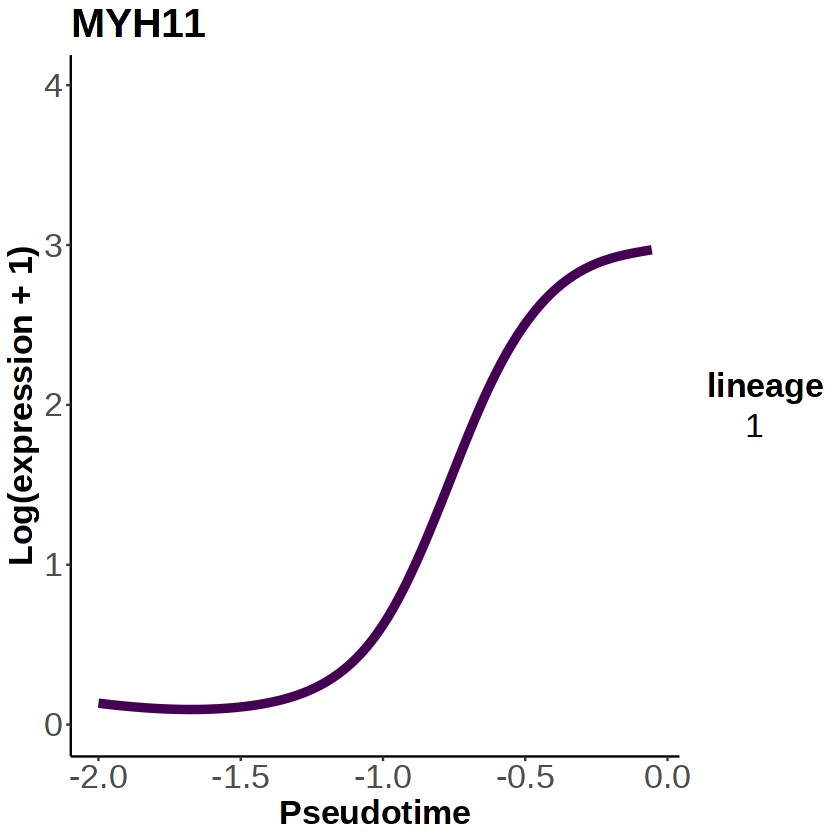

[1] "ERP27"


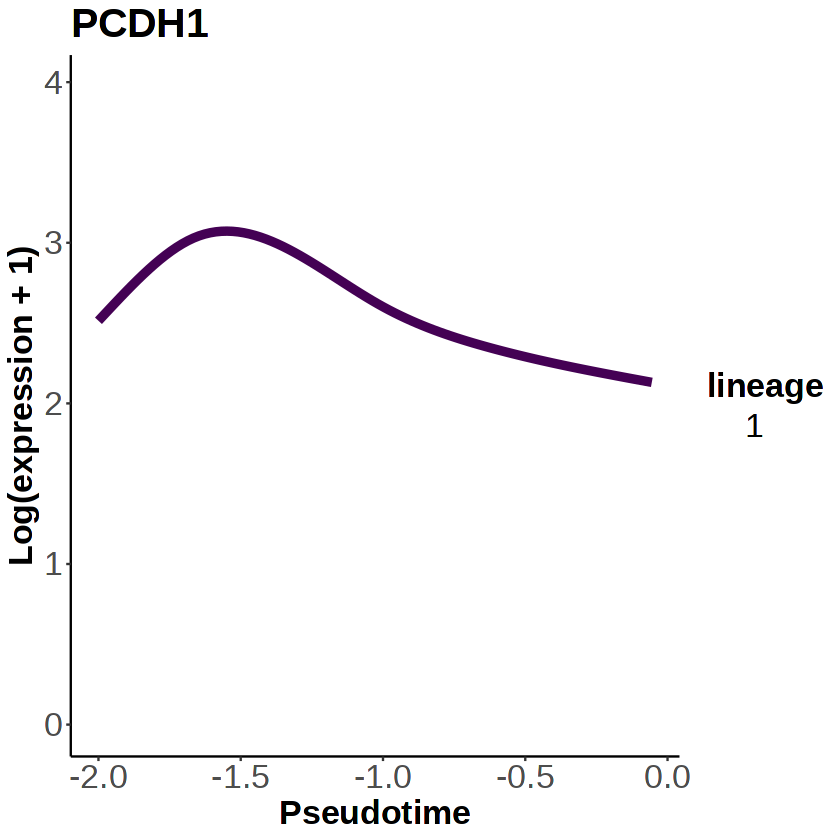

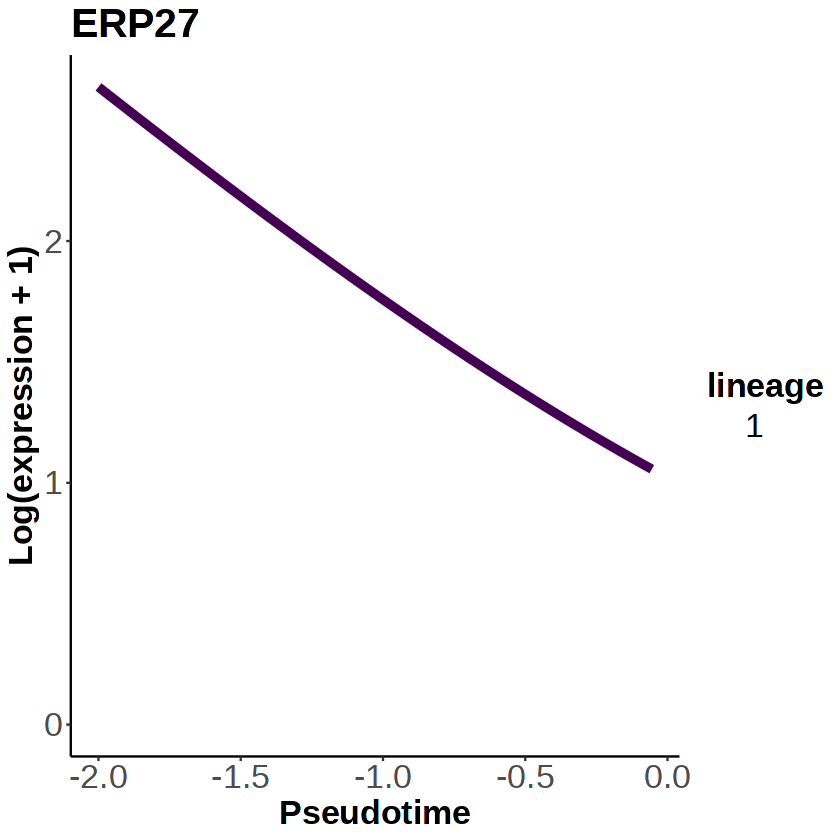

In [63]:
for (gene in tops) {
    print(gene)
    print(plotSmoothers(sce, counts, gene = gene, alpha = 0) + ggtitle(gene) +
                          theme(title = element_text(size = 20, face = 'bold'),
                                axis.title = element_text(size = 20),
                                axis.text = element_text(size = 20),
                                legend.text = element_text(size = 20),
                                legend.title = element_text(size = 20, face = "bold")))
}

In [64]:
model_vals_df <- predictSmooth(models = sce, gene=row.names(assoRes), nPoints=100) # output is 708 genes x 100 pseudospace values 

In [65]:
model_vals_mtx <- predictSmooth(models = sce, gene=row.names(assoRes), nPoints=100, tidy=FALSE)

In [66]:
dim(model_vals_mtx) # 1207 genes x 100 pseudospace values 

[1] 464 100

In [67]:
write.csv(model_vals_mtx, file = '/lustre/scratch126/cellgen/team292/vl6/VISIUM/fallopian_axis_visium_fitted_values_tradeseq_epithelium.csv')


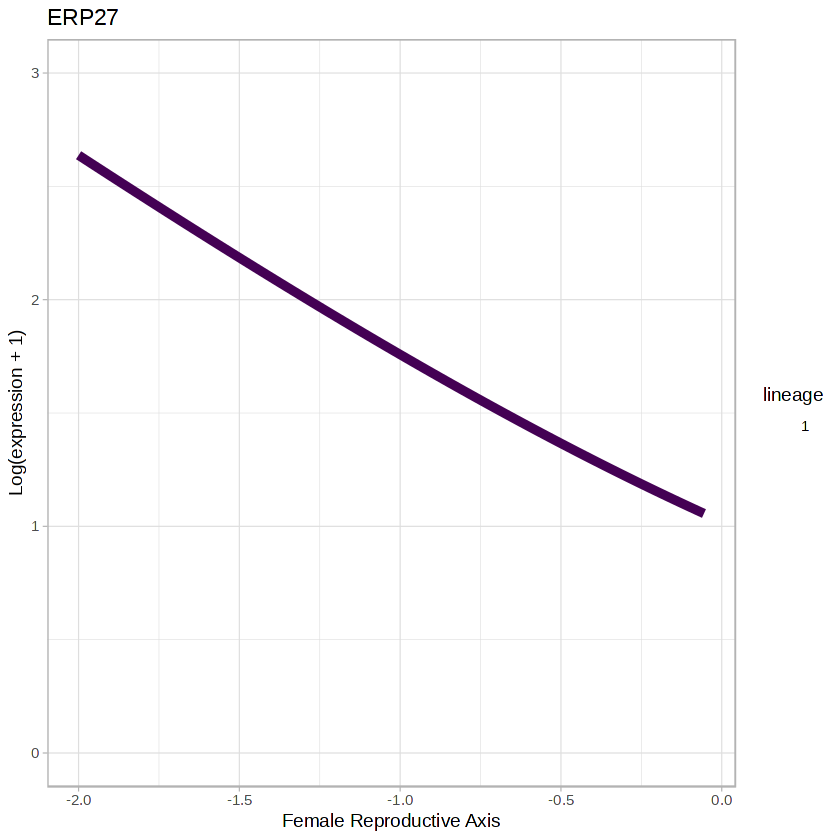

In [68]:
erp27 <- plotSmoothers(sce, counts, gene = 'ERP27', alpha=0, 
                    xlab = "Female Reproductive Axis",
  ylab = "Log(expression + 1)", border = FALSE) + ggtitle("ERP27") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))+ theme_light()+ ylim(0, 3)
erp27

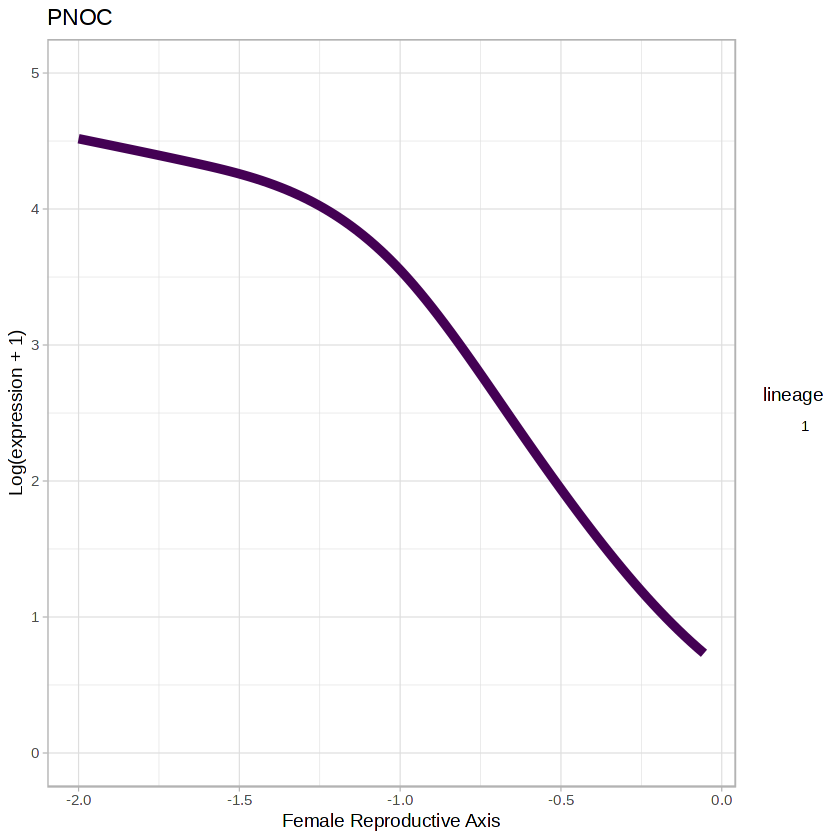

In [69]:
pnoc <- plotSmoothers(sce, counts, gene = 'PNOC', alpha =0, 
                     xlab = "Female Reproductive Axis",
  ylab = "Log(expression + 1)", border = FALSE) + ggtitle("PNOC") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))+ theme_light()+ ylim(0, 5)
pnoc

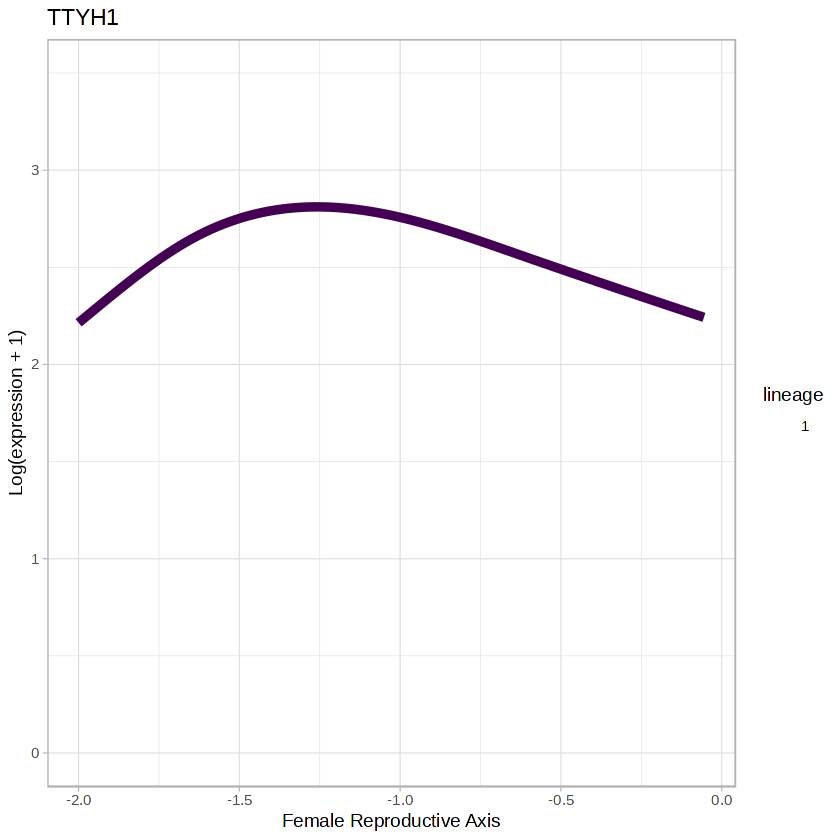

In [70]:
ttyh1 <- plotSmoothers(sce, counts, gene = 'TTYH1', alpha =0, 
                     xlab = "Female Reproductive Axis",
  ylab = "Log(expression + 1)", border = FALSE) + ggtitle("TTYH1") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))+ theme_light()+ ylim(0, 3.5)
ttyh1

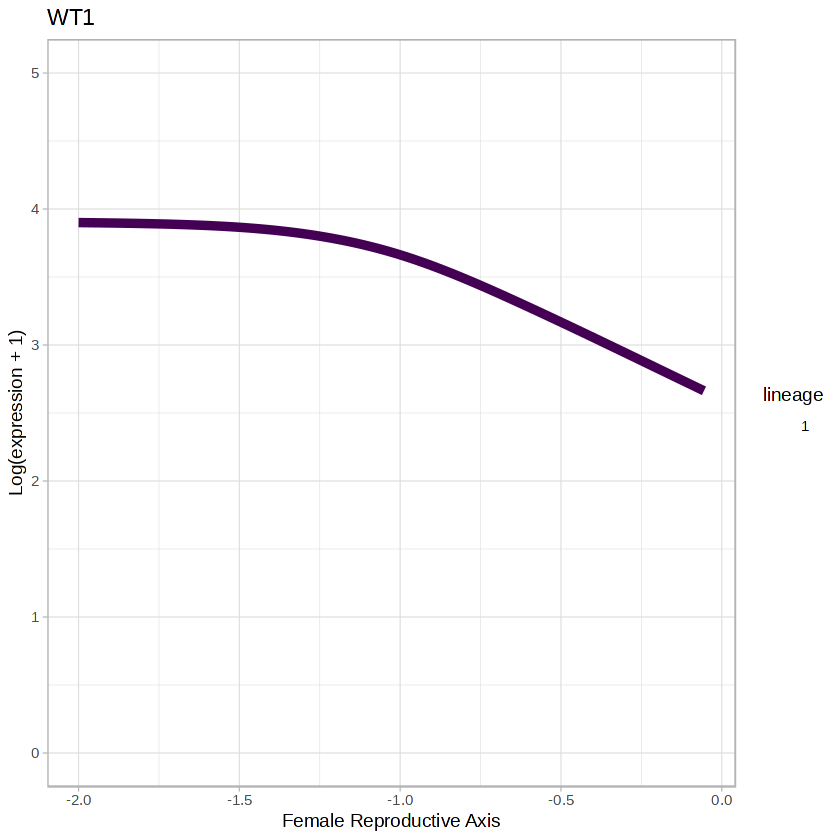

In [71]:
wt1 <- plotSmoothers(sce, counts, gene = 'WT1', alpha=0, 
                     xlab = "Female Reproductive Axis",
  ylab = "Log(expression + 1)", border = FALSE) + ggtitle("WT1") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))+ theme_light()+ ylim(0, 5)
wt1

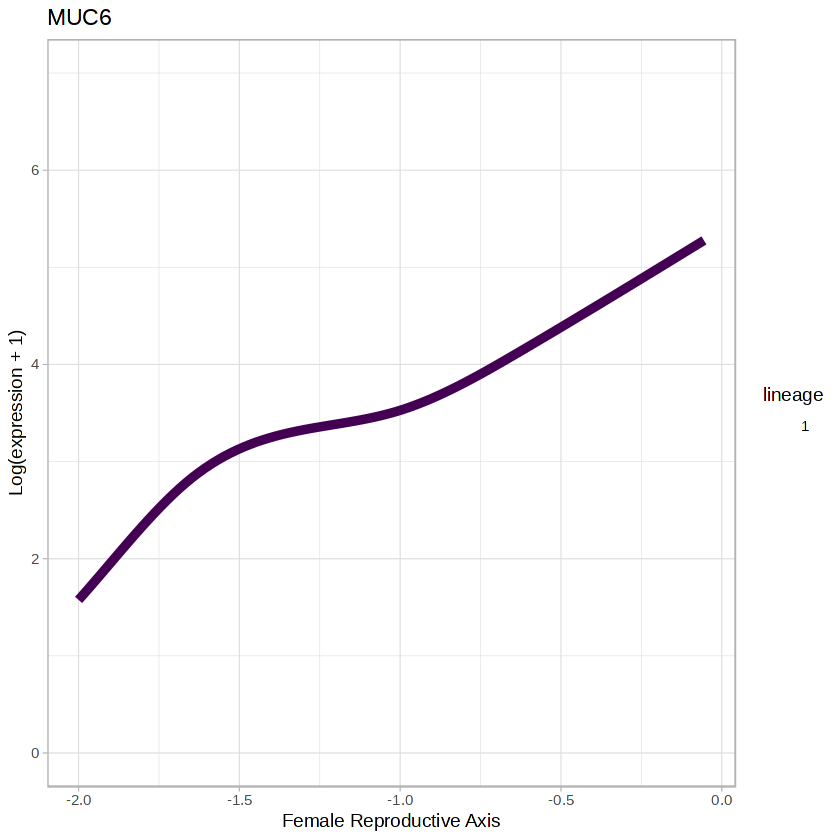

In [72]:
muc6 <- plotSmoothers(sce, counts, gene = 'MUC6', alpha=0, 
                     xlab = "Female Reproductive Axis",
  ylab = "Log(expression + 1)", border = FALSE) + ggtitle("MUC6") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))+ theme_light()+ ylim(0, 7)
muc6

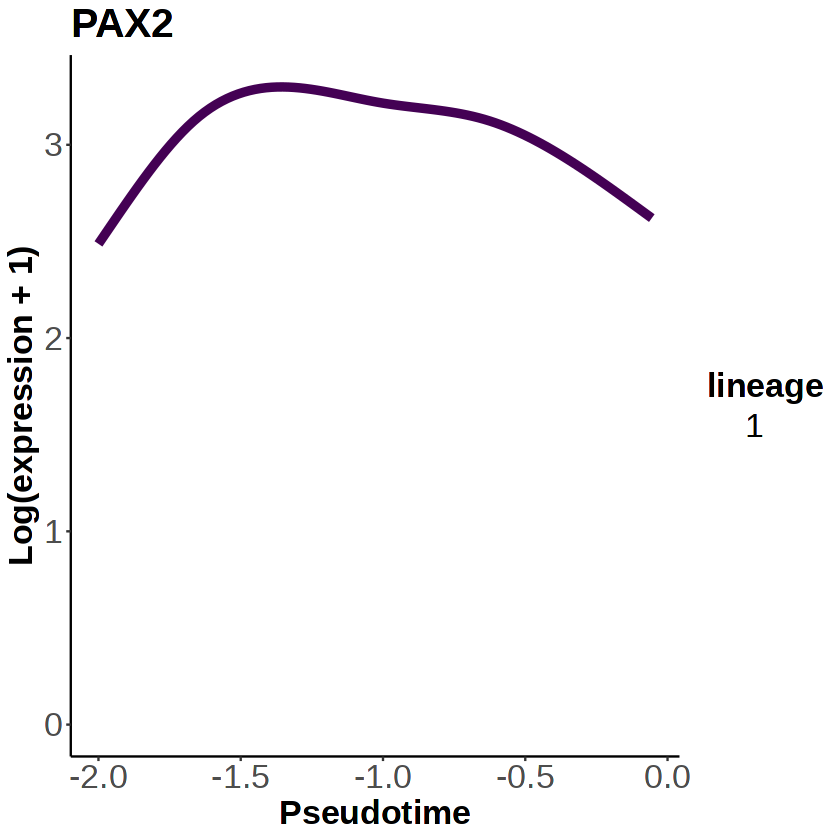

In [73]:
alpk1 <- plotSmoothers(sce, counts, gene = 'PAX2', alpha=0) + ggtitle("PAX2") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))
alpk1

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


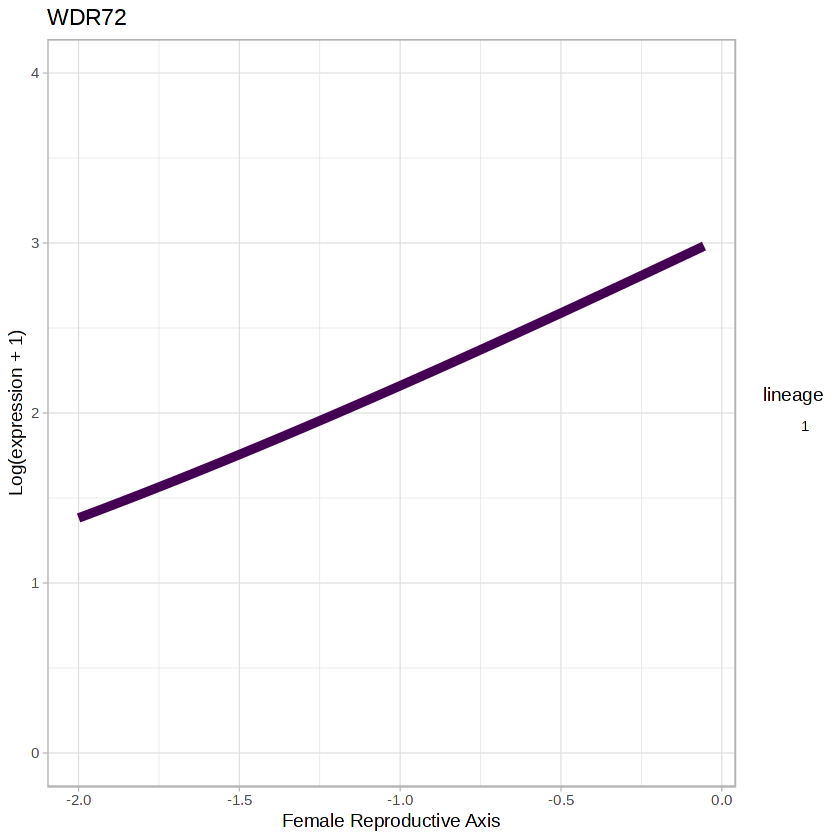

In [84]:
WDR72 <- plotSmoothers(sce, counts, gene = 'WDR72', alpha=0, 
                     xlab = "Female Reproductive Axis",
  ylab = "Log(expression + 1)", border = FALSE) + ggtitle("WDR72") + theme(title = element_text(size = 20, face = 'bold'), axis.title=element_text(size=20), axis.text=element_text(size=20), legend.text = element_text(size=20),
     legend.title = element_text(size=20, face = "bold"))+ theme_light()+ ylim(0, 4)
WDR72

In [85]:
library(gridExtra)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


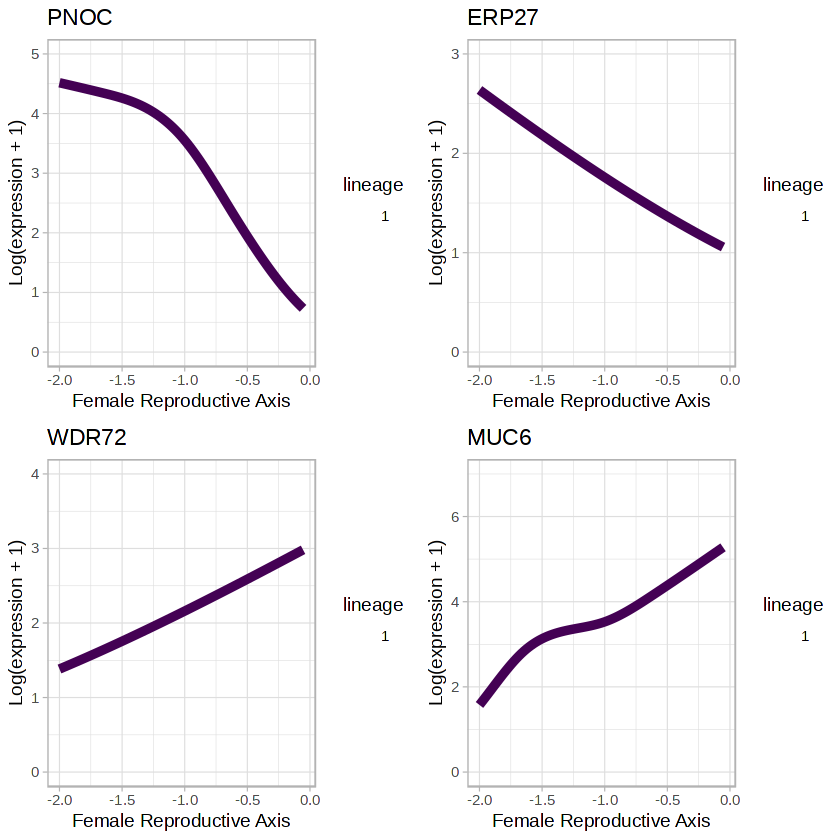

In [86]:
p <- grid.arrange(pnoc, erp27, WDR72, muc6, nrow = 2, ncol = 2)

In [87]:
ggsave('/home/jovyan/RepTract/figures-epithelial/visium_fallopiantube_tradeseq.pdf',
       plot = p,
       width = 8, height = 8, dpi = 300)